<p style="text-align: center;"> *Experiments to reproduce the results* </p>

# <p style="text-align: center; color: darkblue"> Dual Graph Autoencoder </p>

### <p style="text-align: center;"> Author: Ksenia Korovina </p>



___

Installing dependencies:

* `python3`

* `pytorch`, `pyro`

* `gensim`

* `numpy`, `scipy`

* `pandas`

* `sklearn`

* `networkx`

* `matplotlib`

* utilities: `tqdm`

___

## Imports

In [1]:
# DuoGAE imports and settings
from DuoGAE.model import DuoGAE, DuoGAE_NP
from DuoGAE.datasets import *
from DuoGAE.visualization import plot_points_tsne, plot_points, plot_with_classes
from DuoGAE.diff2vec import Diff2Vec
from DuoGAE.node2vec import Node2Vec
from DuoGAE.vgae import eval_gae_lp

from gem.embedding.gf       import GraphFactorization
from gem.embedding.hope     import HOPE
# from gem.embedding.lap      import LaplacianEigenmaps
# from gem.embedding.lle      import LocallyLinearEmbedding
# from gem.embedding.node2vec import node2vec
# from gem.embedding.sdne     import SDNE

import torch
from torch.autograd import Variable

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score,\
                            average_precision_score,\
                            accuracy_score,\
                            f1_score,\
                            log_loss

# Jupyter display utilities
from IPython.display import clear_output
from tqdm import tqdm_notebook

# other imports
from collections import defaultdict
from itertools import product
from copy import copy
import json
import warnings
warnings.filterwarnings("ignore")

C:\Users\mi\miniconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
from datetime import datetime

In [3]:
def interval_evaluation_lp(dataset, model, params, seeds):
    """
    Average across different runs on a fixed dataset.
    :param: dataset - GraphDataset instance
    :param: model - DuoGAE object
    :param: params - dictionary of DuoGAE.eval_lp() keyword args

    :return: res={"accuracy": [0.7, 0.65, ...], ...} (defaultdict)
    """
    res = defaultdict(list)
    logs = {}

    for seed in seeds:
        clear_output(wait=True)
        params['seed'] = seed
        log = model.eval_lp(dataset, **params)
        res_run = model.evaluate(dataset)
        print(log.keys())
        logs[seed] = log
        for met in res_run:
            res[met].append(res_run[met])
    return res, logs


def to_mean_and_std(results):
    res = {}
    for r in results:
        case = results[r]
        tmp = {}
        for met in case:
            tmp[met] = {'mean': np.mean(case[met]), 
                        'std':  np.std(case[met])}
        res[r] = copy(tmp)
    return res

# ! mkdir results

RES_FOLDER="./results_time_complexity/"

def load_result(name):
    with open(RES_FOLDER+name+".json") as fp:
        js = json.load(fp=fp)
    return js


def save_result(results, name):
    with open(RES_FOLDER+name+".json", "w") as fp:
        json.dump(results, fp=fp)

## Link prediction

Miscellaneous features of the model

<a style="color: red"> TODO: </a> add randomization over datasets

<a style="color: red"> TODO: </a> for every experiment, repeat it on several datasets and select the best(-looking) positive case for each dataset

### Masking [<a style="color: green"> V </a>]

Testing $\beta$ -masking for autoencoders, larger the mask means larger relative penalty for failing to reconstruct positive values of the adjacency matrices. For starters, let's test equal masks for both primal and dual graph.

In [4]:
from Benchmarks.models import BaseBenchmarkWrapper

Using backend: pytorch


In [5]:
from Benchmarks.models import BaseBenchmarkWrapper
import pickle

In [8]:
%%time
# Exp 1. mask

# the default parameters are chosen to be 'safe-optimal',
# so we only need to vary the mask in the loop

reset_params = {}

# subgraph_configs = [{'size': 1000,  'seed': 10},
#                     {'size': 1000,  'seed': 20},
#                     {'size': 2000, 'seed': 30},
#                     {'size': 2000, 'seed': 40},
#                     {'size': 2000, 'seed': 50}]
subgraph_configs = [{'size': 2000, 'seed': 30},
#                     {'size': 2000, 'seed': 40},
#                     {'size': 2000, 'seed': 50}
                   ]

# seeds = list(range(5))
seeds = [5]

#########################################################


dataset_gens = {
    'hepth': HepThDataset,
    'astro': AstroPhDataset,
    'hse': HSEDataset,
    'facebook': FacebookDataset,
    'blog_catalog': BlogCatalogDataset
}

# model = BaseBenchmarkWrapper("gcn", {})
# for (d, constr) in dataset_gens.items():
#     mask = 0
#     for m in ["gat", "graphsage", "gcn"]:
#         model = BaseBenchmarkWrapper(m, {})
#         # Dictionary mapping: mask -> {accuracy: [0.7, 0.65, ...], ...}
#         results_masking = {}

#         reset_params['mask'] = reset_params['mask_dual'] = 0
#         reset_params["num_epochs"] = 300
#         tmp = defaultdict(list)
#         logs_res = []
#         for conf in subgraph_configs:
#             dataset = constr(**conf)
#             print(dataset.adj.shape)
#             res, logs = interval_evaluation_lp(dataset, model,
#                                          params=reset_params,
#                                          seeds=seeds)
#             logs_res.append(logs)
#             for met in res:
#                 tmp[met].extend(res[met])
#         results_masking[mask] = copy(tmp)

#         # done, saving
#         # save_result(to_mean_and_std(results_masking), "mask_hepth")
#         save_result(to_mean_and_std(results_masking), f"{m}_{d}")
#         with open(f"results_time_complexity/{m}_{d}_logs.pickle", "wb") as f:
#             pickle.dump(logs, f)

Wall time: 0 ns


In [9]:
dataset_gens = {
#     'hepth': HepThDataset,
#     'astro': AstroPhDataset,
    'hse': HSEDataset,
#     'facebook': FacebookDataset,
#     'blog_catalog': BlogCatalogDataset
}

Preprocessing time: 0.13s
Preprocessing time: 5.51s


dict_keys(['train_elbo', 'train_added', 'time_per_epoch', 'accuracy_train', 'roc_train', 'ap_train', 'f1_train', 'accuracy_test', 'roc_test', 'ap_test', 'f1_test'])


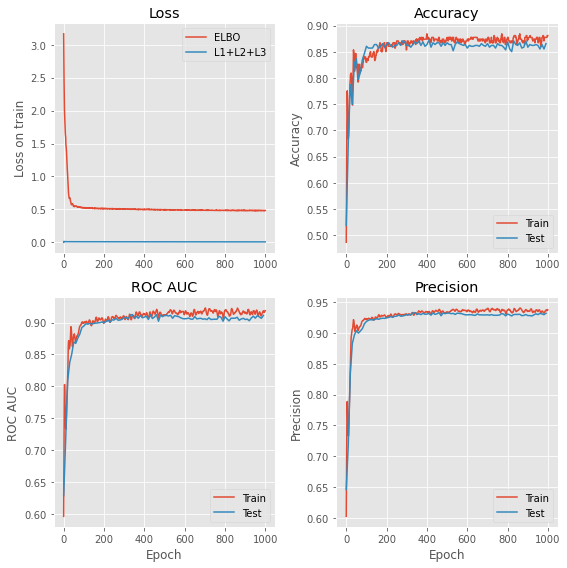

In [15]:

reset_params = dict(n_hidden=32, n_latent=32,
dropout=0.5, dropout_dual=0.5,
mask=-0.1, mask_dual=2e-2,
lambd=0.005, lambd_dual=0.2, co_reg=0.1, verbose=False)
reset_params["num_epochs"] = 1000
for (d, constr) in dataset_gens.items():
    mask = 0
#     reset_params['mask'] = reset_params['mask_dual'] = 0
    results_masking = {}
    m = "Jonnee"
    tmp = defaultdict(list)
    logs_res = []
    for conf in subgraph_configs:
        dataset = constr(**conf)
        res, logs = interval_evaluation_lp(dataset, DuoGAE(),
                                     params=reset_params,
                                     seeds=seeds)
        logs_res.append(logs)
        for met in res:
            tmp[met].extend(res[met])
    results_masking[mask] = copy(tmp)

    save_result(to_mean_and_std(results_masking), f"{m}_{d}")
    with open(f"results_time_complexity3/{m}_{d}_logs.pickle", "wb") as f:
            pickle.dump(logs, f)
#     break

In [ ]:
%%time
# Exp 1. mask
# TODO: see if mask != mask_dual is useful

# the default parameters are chosen to be 'safe-optimal',
# so we only need to vary the mask in the loop

reset_params = {}

# subgraph_configs = [{'size': 1000,  'seed': 10},
#                     {'size': 1000,  'seed': 20},
#                     {'size': 2000, 'seed': 30},
#                     {'size': 2000, 'seed': 40},
#                     {'size': 2000, 'seed': 50}]
subgraph_configs = [{'size': 2000, 'seed': 30},
                    {'size': 2000, 'seed': 40},
                    {'size': 2000, 'seed': 50}]

seeds = list(range(5))
seeds = [5]

#########################################################

model = DuoGAE()

# Dictionary mapping: mask -> {accuracy: [0.7, 0.65, ...], ...}
results_masking = {}

reset_params['mask'] = 0.1

for mask in tqdm_notebook([-1e-2, 0., 0.1, 0.2, 1.], leave=False):
    reset_params['mask_dual'] = mask
    tmp = defaultdict(list)
    for conf in subgraph_configs:
        dataset = AstroPhDataset(**conf)
        res = interval_evaluation_lp(dataset, model,
                                     params=reset_params,
                                     seeds=seeds)
        for met in res:
            tmp[met].extend(res[met])
    results_masking[mask] = copy(tmp)

# done, saving
save_result(to_mean_and_std(results_masking), "mask_for_dual_astro")

Words

___

### Laplace [<a style="color: green"> V </a>]

Laplacian regularization for added reconstruction of immediate neighborhoods.

In [ ]:
# Exp 2. with and without lambd and lambd_dual

reset_params = {}

# subgraph_configs = [{'size': 500,  'seed': 10},
#                     {'size': 500,  'seed': 20},
#                     {'size': 1000, 'seed': 30},
#                     {'size': 1000, 'seed': 40},
#                     {'size': 1000, 'seed': 50}]

# subgraph_configs = [{'size': 1000,  'seed': 10},
#                     {'size': 1000,  'seed': 20},
#                     {'size': 2000, 'seed': 30},
#                     {'size': 2000, 'seed': 40},
#                     {'size': 2000, 'seed': 50}]
subgraph_configs = [{'size': 2000, 'seed': 30},
                    {'size': 2000, 'seed': 40},
                    {'size': 2000, 'seed': 50}]

seeds = list(range(3))

In [ ]:
DatasetInit = HepThDataset  #AstroPhDataset

Preprocessing time: 0.12s
Preprocessing time: 1.33s
CPU times: user 5h 51min 21s, sys: 48min 41s, total: 6h 40min 2s
Wall time: 2h 18min 55s


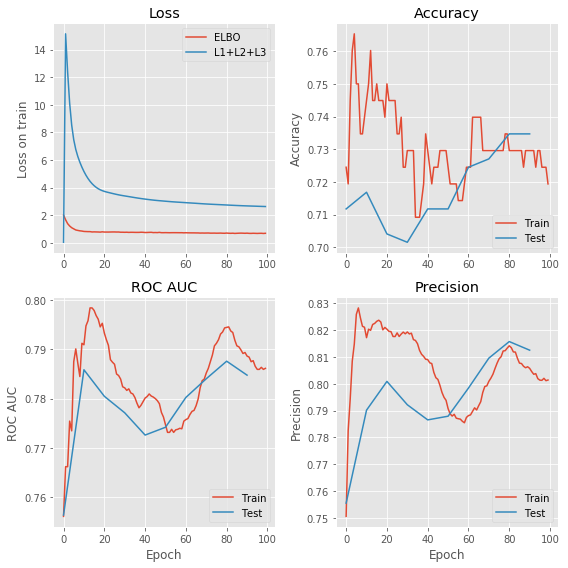

In [109]:
%%time

model = DuoGAE()

# Dictionary mapping: mask -> {accuracy: [0.7, 0.65, ...], ...}
results_laplace = {}

for lambd in tqdm_notebook([0., 0.001, 0.01, 0.1, 1., 10.], leave=False):
    reset_params['lambd'] = reset_params['lambd_dual'] = lambd
    reset_params['co_reg'] = lambd / 4
    tmp = defaultdict(list)
    for conf in subgraph_configs:
        dataset = DatasetInit(**conf)
        res = interval_evaluation_lp(dataset, model,
                                     params=reset_params,
                                     seeds=seeds)
        for met in res:
            tmp[met].extend(res[met])
    results_laplace[lambd] = copy(tmp)

save_result(to_mean_and_std(results_laplace), "laplace_hepth")
# save_result(to_mean_and_std(results_laplace), "laplace_astro")

In [8]:
# results_laplace
# load_result("laplace_hepth")
load_result("laplace_astro")

{'0.0': {'accuracy': {'mean': 0.593912242155336, 'std': 0.05409228306574214},
  'ap_score': {'mean': 0.8117253476708595, 'std': 0.04402483257159798},
  'f1_score': {'mean': 0.6491114149570697, 'std': 0.04625949890498941},
  'logloss': {'mean': 0.5748423598002573, 'std': 0.03246328007786497},
  'roc_score': {'mean': 0.7362894601980338, 'std': 0.06209082154649511}},
 '0.001': {'accuracy': {'mean': 0.5977588059671721,
   'std': 0.06205118939035049},
  'ap_score': {'mean': 0.809512368849258, 'std': 0.05475217923604241},
  'f1_score': {'mean': 0.6545655120209379, 'std': 0.050067569316619105},
  'logloss': {'mean': 0.576981681765814, 'std': 0.03976773922309046},
  'roc_score': {'mean': 0.7354301990670064, 'std': 0.07273762901397889}},
 '0.01': {'accuracy': {'mean': 0.5921412392722574, 'std': 0.05801228452620246},
  'ap_score': {'mean': 0.8092293409039777, 'std': 0.054841102028713534},
  'f1_score': {'mean': 0.6505735825172303, 'std': 0.047827317551276706},
  'logloss': {'mean': 0.57701647011

Preprocessing time: 0.14s
Preprocessing time: 0.87s


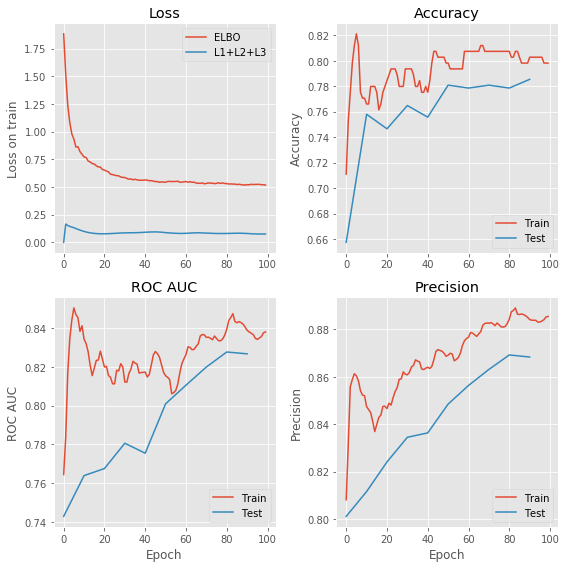

In [110]:
# TODO: see if lambd != lambd_dual is useful
model = DuoGAE()

# Dictionary mapping: mask -> {accuracy: [0.7, 0.65, ...], ...}
results_laplace = {}
DatasetInit = AstroPhDataset

reset_params['lambd'] = 0.1

for lambd in tqdm_notebook([0., 0.04, 0.4, 4.], leave=False):
    reset_params['lambd_dual'] = lambd
    reset_params['co_reg'] = lambd / 4
    tmp = defaultdict(list)
    for conf in subgraph_configs:
        dataset = DatasetInit(**conf)
        res = interval_evaluation_lp(dataset, model,
                                     params=reset_params,
                                     seeds=seeds)
        for met in res:
            tmp[met].extend(res[met])
    results_laplace[lambd] = copy(tmp)

# save_result(to_mean_and_std(results_laplace), "laplace_hepth")
save_result(to_mean_and_std(results_laplace), "laplace_for_dual_astro")

Words

___

### Duals [<a style="color: green"> V </a>]

In [111]:
# Exp 3. with and without co_reg

# same settings as above
reset_params = {}

# subgraph_configs = [{'size': 500,  'seed': 10},
#                     {'size': 500,  'seed': 20},
#                     {'size': 1000, 'seed': 30},
#                     {'size': 1000, 'seed': 40},
#                     {'size': 1000, 'seed': 50}]

# subgraph_configs = [{'size': 1000,  'seed': 10},
#                     {'size': 1000,  'seed': 20},
#                     {'size': 2000, 'seed': 30},
#                     {'size': 2000, 'seed': 40},
#                     {'size': 2000, 'seed': 50}]

subgraph_configs = [{'size': 2000, 'seed': 30},
                    {'size': 2000, 'seed': 40},
                    {'size': 2000, 'seed': 50}]


seeds = list(range(3))

Preprocessing time: 0.13s
Preprocessing time: 0.87s
CPU times: user 5h 44min 31s, sys: 46min 2s, total: 6h 30min 33s
Wall time: 2h 12min 31s


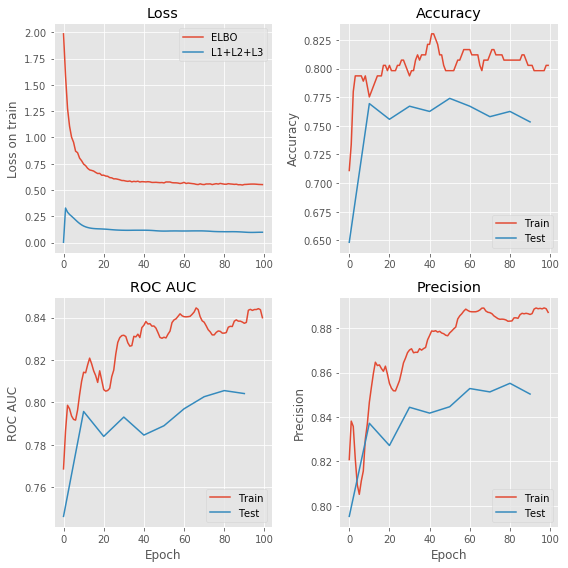

In [112]:
%%time

model = DuoGAE()

# Dictionary mapping: mask -> {accuracy: [0.7, 0.65, ...], ...}
results_ddual = {}

for co_reg in tqdm_notebook([0., 0.001, 0.01, 0.1, 1., 10.], leave=False):
    #reset_params['lambd'] = co_reg * 2
    #reset_params['lambd'] = co_reg * 4
    reset_params['co_reg'] = co_reg
    tmp = defaultdict(list)
    for conf in subgraph_configs:
        # dataset = HepThDataset(**conf)
        dataset = AstroPhDataset(**conf)
        res = interval_evaluation_lp(dataset, model,
                                     params=reset_params,
                                     seeds=seeds)
        for met in res:
            tmp[met].extend(res[met])
    results_ddual[co_reg] = copy(tmp)

# save_result(to_mean_and_std(results_ddual), "ddual_hepth")
save_result(to_mean_and_std(results_ddual), "ddual_astro")

In [11]:
load_result("ddual_hepth")

{'0.0': {'accuracy': {'mean': 0.5906115240590379, 'std': 0.05982444837682597},
  'ap_score': {'mean': 0.8100644167101104, 'std': 0.05181550199123037},
  'f1_score': {'mean': 0.6500970290881846, 'std': 0.04992449883557483},
  'logloss': {'mean': 0.5753457616034037, 'std': 0.03382363027918864},
  'roc_score': {'mean': 0.7395856473439458, 'std': 0.06349918716703454}},
 '0.001': {'accuracy': {'mean': 0.5925005810759559,
   'std': 0.05487571215419745},
  'ap_score': {'mean': 0.8123249087336859, 'std': 0.05328172349100067},
  'f1_score': {'mean': 0.6527397968532206, 'std': 0.04859067307077984},
  'logloss': {'mean': 0.577716817051313, 'std': 0.03502618489059522},
  'roc_score': {'mean': 0.7402445605042461, 'std': 0.07000351283841105}},
 '0.01': {'accuracy': {'mean': 0.611759966733921, 'std': 0.04774413523910533},
  'ap_score': {'mean': 0.8178087673698942, 'std': 0.04802444264868983},
  'f1_score': {'mean': 0.6611718936965107, 'std': 0.046134260720192145},
  'logloss': {'mean': 0.572734999352

Words

___

### Choosing D_feat [<a style="color: green"> V </a>]

In [132]:
# Exp 4. choosing feature dimension D

# same settings as above
reset_params = {}

# subgraph_configs = [{'size': 500,  'seed': 10},
#                     {'size': 500,  'seed': 20},
#                     {'size': 1000, 'seed': 30},
#                     {'size': 1000, 'seed': 40},
#                     {'size': 1000, 'seed': 50}]

subgraph_configs = [{'size': 1000,  'seed': 10},
                    {'size': 1000,  'seed': 20},
                    {'size': 2000, 'seed': 30},
                    {'size': 2000, 'seed': 40},
                    {'size': 2000, 'seed': 50}]

subgraph_configs = [{'size': 2000, 'seed': 30},
                    {'size': 2000, 'seed': 40},
                    {'size': 2000, 'seed': 50}]

seeds = list(range(5))
seeds = [5]

Preprocessing time: 0.17s
Preprocessing time: 1.55s
CPU times: user 1h 41min 44s, sys: 16min 20s, total: 1h 58min 4s
Wall time: 42min 56s


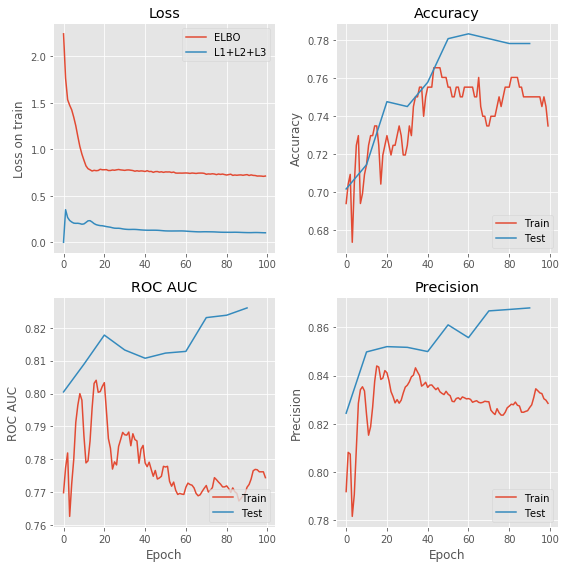

In [137]:
%%time

model = DuoGAE()

# Dictionary mapping: mask -> {accuracy: [0.7, 0.65, ...], ...}
results_fdim = {}
reset_params = {'n_latent': 64, 'n_hidden': 2 * 64}

for fdim in tqdm_notebook([8, 16, 32, 64, 128], leave=False):
    reset_params['feat_dim'] = fdim
    tmp = defaultdict(list)
    for conf in subgraph_configs:
        dataset = HepThDataset(**conf)
        res = interval_evaluation_lp(dataset, model,
                                     params=reset_params,
                                     seeds=seeds)
        for met in res:
            tmp[met].extend(res[met])
    results_fdim[fdim] = copy(tmp)

save_result(to_mean_and_std(results_fdim), "fdim_hepth")

In [14]:
load_result("fdim_hepth")

{'16': {'accuracy': {'mean': 0.6014800335652742, 'std': 0.05698432748023654},
  'ap_score': {'mean': 0.8124923443170369, 'std': 0.04750167314966321},
  'f1_score': {'mean': 0.6573291134165261, 'std': 0.046994099483756935},
  'logloss': {'mean': 0.5779449462078098, 'std': 0.03393378890036871},
  'roc_score': {'mean': 0.7421770584535168, 'std': 0.06244333449227075}},
 '32': {'accuracy': {'mean': 0.5916086426425811, 'std': 0.05952603631463527},
  'ap_score': {'mean': 0.8111684328560377, 'std': 0.0564087716736948},
  'f1_score': {'mean': 0.6528984966891838, 'std': 0.05369453832255977},
  'logloss': {'mean': 0.5763630510622938, 'std': 0.03328543386098512},
  'roc_score': {'mean': 0.7387094556038489, 'std': 0.07622885758935749}},
 '64': {'accuracy': {'mean': 0.5880463248434835, 'std': 0.05816798875180418},
  'ap_score': {'mean': 0.8092292195489013, 'std': 0.05899450373720062},
  'f1_score': {'mean': 0.6477259844728707, 'std': 0.055629955515075935},
  'logloss': {'mean': 0.5812513162471049, '

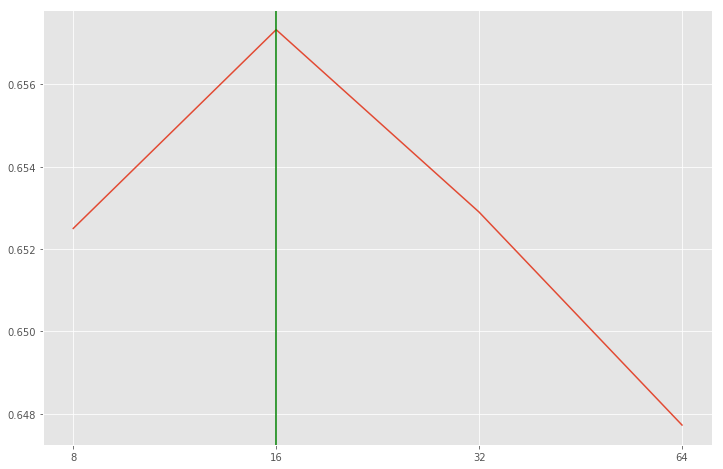

In [158]:
# построить графики ROC и F1 для d=16
res = load_result("fdim_hepth_d16")

met = "roc_score"
met = "f1_score"
dims = list(res.keys())
plt.figure(figsize=(12, 8))
plt.plot(dims, list(res[d][met]['mean'] for d in dims))
plt.axvline(x=1., color='g')
plt.show()

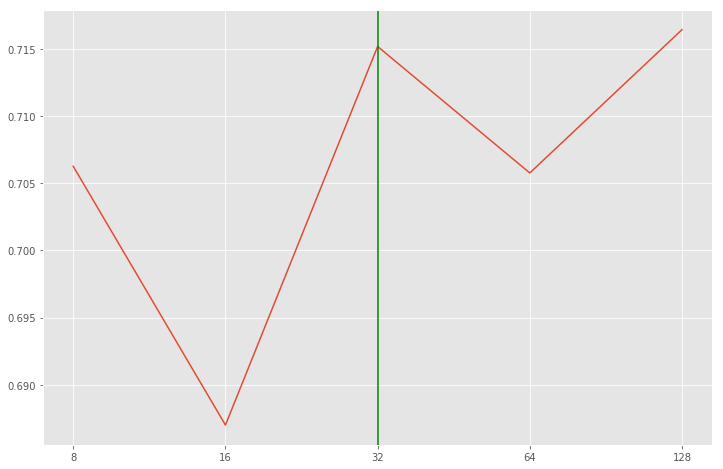

In [160]:
# построить графики ROC и F1 для d=64
res = load_result("fdim_hepth")

# met = "roc_score"
# met = "f1_score"

dims = list(res.keys())
plt.figure(figsize=(12, 8))
plt.plot(dims, list(res[d][met]['mean'] for d in dims))
plt.axvline(x=2., color='g')
plt.show()

Words
___

### Choosing Seq model (FeatGen) [<a style="color: green"> V </a>]

#### On an unweighted dataset

In [3]:
%%time
# Exp 5. diff2vec/node2vec

# same settings as above
reset_params = {}

# subgraph_configs = [{'size': 500,  'seed': 10},
#                     {'size': 500,  'seed': 20},
#                     {'size': 1000, 'seed': 30},
#                     {'size': 1000, 'seed': 40},
#                     {'size': 1000, 'seed': 50}]

subgraph_configs = [{'size': 1000,  'seed': 10},
                    {'size': 1000,  'seed': 20},
                    {'size': 2000, 'seed': 30},
                    {'size': 2000, 'seed': 40},
                    {'size': 2000, 'seed': 50}]

seeds = list(range(5))

model = DuoGAE()

results_seq = {}

# everything is with node2vec here
for emb_type in tqdm_notebook(["dummy", "node2vec", "diff2vec"], leave=False):
    reset_params['emb_type'] = emb_type
    tmp = defaultdict(list)
    for conf in subgraph_configs:
        dataset = HepThDataset(**conf)
        res = interval_evaluation_lp(dataset, model,
                                     params=reset_params,
                                     seeds=seeds)
        for met in res:
            tmp[met].extend(res[met])
    results_seq[emb_type] = copy(tmp)

save_result(to_mean_and_std(results_seq), "seq_hepth")

Preprocessing time: 0.02s
Preprocessing time: 0.04s


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


KeyboardInterrupt: 

In [4]:
load_result("seq_hepth")

{'diff2vec': {'accuracy': {'mean': 0.7222550398469895,
   'std': 0.0345939544722537},
  'ap_score': {'mean': 0.7911493886199856, 'std': 0.051868148226609664},
  'f1_score': {'mean': 0.702782248745483, 'std': 0.05452194838279778},
  'logloss': {'mean': 0.5945020020010858, 'std': 0.02664819511095322},
  'roc_score': {'mean': 0.7709305762434008, 'std': 0.049524656430549624}},
 'dummy': {'accuracy': {'mean': 0.5693133122770061,
   'std': 0.037531575100431064},
  'ap_score': {'mean': 0.5734580270903915, 'std': 0.06331668671471484},
  'f1_score': {'mean': 0.6656736980347442, 'std': 0.03092278275565743},
  'logloss': {'mean': 0.6931352576997817, 'std': 1.4947717472258004e-05},
  'roc_score': {'mean': 0.5925953034638131, 'std': 0.06261497790326723}},
 'node2vec': {'accuracy': {'mean': 0.6120930294987121,
   'std': 0.06028601285474701},
  'ap_score': {'mean': 0.8133120700081895, 'std': 0.05493977209036774},
  'f1_score': {'mean': 0.6628564361221325, 'std': 0.05944767240476673},
  'logloss': {'m

** Visualization **

In [61]:
def plot_points_tsne(emb, seed=42, labels=None, figsize=(12, 8)):
    tsne = TSNE(n_components=2, verbose=0, perplexity=40,
                n_iter=300, random_state=seed)
    
    tsne_results = tsne.fit_transform(emb)

    vis_x = tsne_results[:, 0]
    vis_y = tsne_results[:, 1]
    
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(1,1,1) # two rows, one column, first plot
    plt.scatter(vis_x, vis_y, alpha=0.5)
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    ax.set_facecolor('white')
    plt.show()

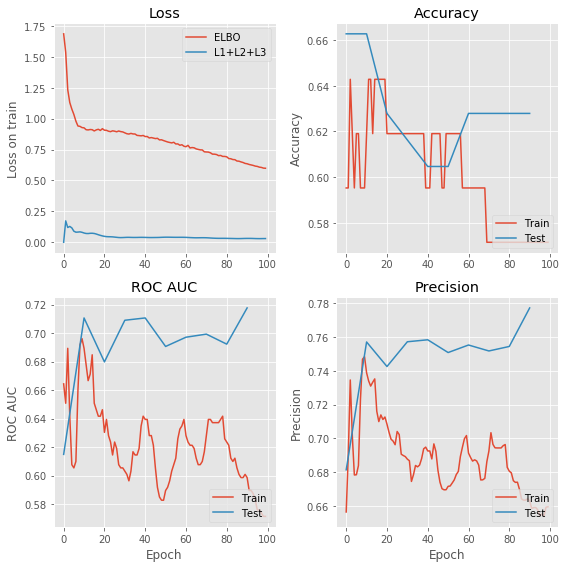

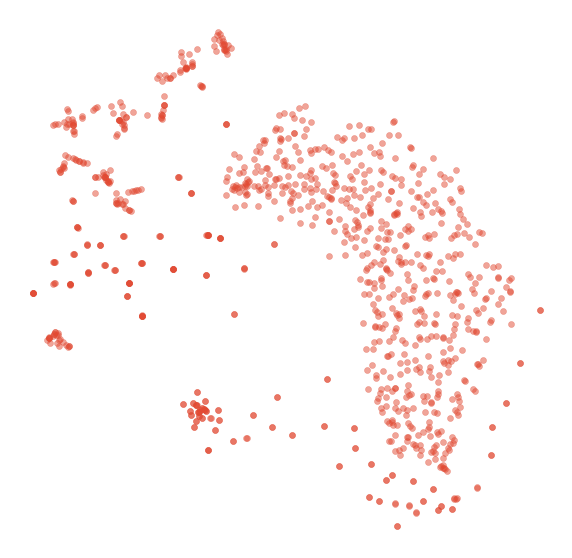

In [66]:
d = 50
dataset = HepThDataset(size=1000, seed=19)
model = DuoGAE()
model.eval_lp(dataset, emb_type="node2vec", num_epochs=100, n_latent=d, n_hidden=d * 5, feat_dim=100)
clear_output()
plot_points_tsne(model.gae.get_embeddings().data,
                 figsize=(10, 10), seed=10)

In [67]:
# Formally evaluate clustering quality using KMeans 
# (with the number of clusters we observe on the viz?)
# maybe should be the same for a single dataset

embs = model.gae.get_embeddings().data
kmeans_model = KMeans(n_clusters=3, random_state=1).fit(embs)
labels = kmeans_model.labels_
silhouette_score(embs, labels, metric='euclidean')

0.618105

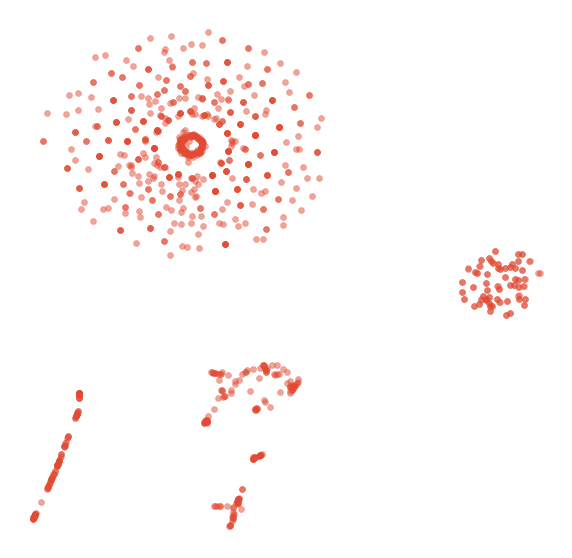

In [75]:
# d = 50
# dataset = HepThDataset(size=1000, seed=19)
# model = DuoGAE()
# model.eval_lp(dataset, emb_type="diff2vec", num_epochs=100, 
#               n_latent=d, n_hidden=d * 5, feat_dim=100)
# clear_output()
plot_points_tsne(model.gae.get_embeddings().data,
                 figsize=(10, 10),seed=2)

In [76]:
embs = model.gae.get_embeddings().data
kmeans_model = KMeans(n_clusters=3, random_state=1).fit(embs)
labels = kmeans_model.labels_
silhouette_score(embs, labels, metric='euclidean')

0.75277483

#### On weighted dataset (HSE)

In [32]:
%%time
# Exp 5. diff2vec/node2vec
# TODO - same as above but on HSE

# same settings as above
reset_params = {}

seeds = list(range(10, 15))

dataset = HSEDataset()
model = DuoGAE()

results_seq = {}

# everything is with node2vec here
for emb_type in tqdm_notebook(["dummy", "node2vec", "diff2vec"], leave=False):
    reset_params['emb_type'] = emb_type
    if emb_type == "diff2vec":
        for t in (0, 1):
            reset_params['weighted_seq'] = t
            results_seq[emb_type + str(t)] = interval_evaluation_lp(dataset, model,
                                                           params=reset_params,
                                                           seeds=seeds)
    else:
        results_seq[emb_type] = interval_evaluation_lp(dataset, model,
                                                       params=reset_params,
                                                       seeds=seeds)

save_result(to_mean_and_std(results_seq), "seq_hse")

Preprocessing time: 0.21s
Preprocessing time: 13.22s


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


CPU times: user 2h 23min 5s, sys: 32min 35s, total: 2h 55min 41s
Wall time: 1h 19min 59s


In [31]:
load_result("seq_hse")

{'diff2vec0': {'accuracy': {'mean': 0.5476190476190477,
   'std': 0.0170068027210884},
  'ap_score': {'mean': 0.845841114402173, 'std': 0.009994220565252676},
  'f1_score': {'mean': 0.6329360549187939, 'std': 0.017337169124922003},
  'logloss': {'mean': 0.5462054628954173, 'std': 0.006350587391245277},
  'roc_score': {'mean': 0.7796230737192836, 'std': 0.01546230737192833}},
 'diff2vec1': {'accuracy': {'mean': 0.5425170068027212,
   'std': 0.005102040816326536},
  'ap_score': {'mean': 0.8481672767967549, 'std': 0.005808783568278297},
  'f1_score': {'mean': 0.6302813975448536, 'std': 0.00705193578847968},
  'logloss': {'mean': 0.5414582608028257, 'std': 0.00025432299689931437},
  'roc_score': {'mean': 0.7818617242815494, 'std': 0.003852561432736379}}}

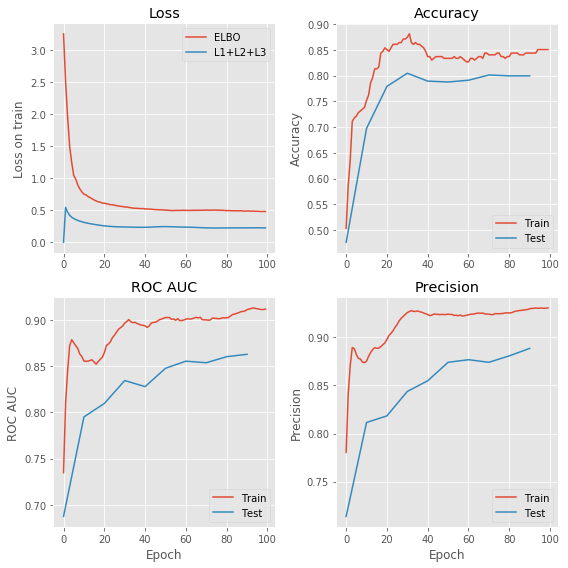

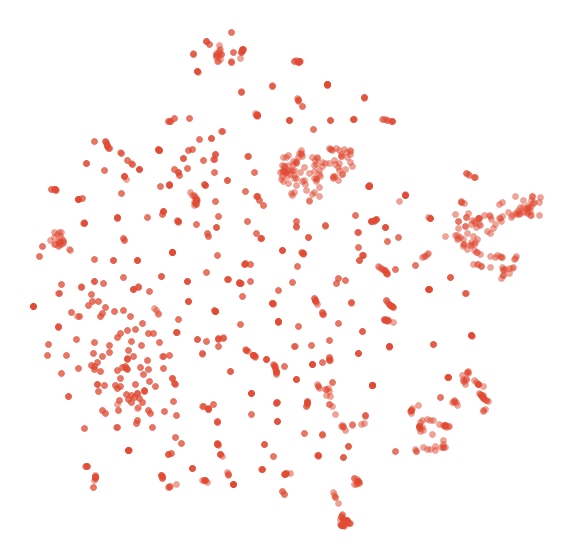

In [77]:
dataset = HSEDataset()
model = DuoGAE()
model.eval_lp(dataset, emb_type="node2vec")
clear_output()
plot_points_tsne(model.gae.get_embeddings().data,
                 figsize=(10, 10))

In [78]:
embs = model.gae.get_embeddings().data
kmeans_model = KMeans(n_clusters=3, random_state=1).fit(embs)
labels = kmeans_model.labels_
silhouette_score(embs, labels, metric='euclidean')

0.25642315

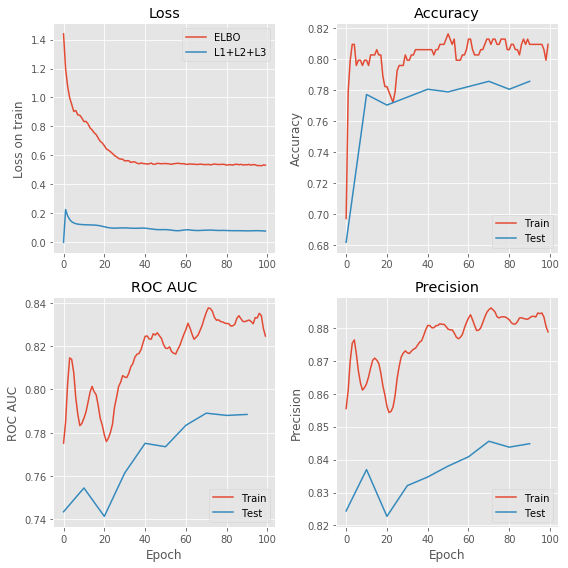

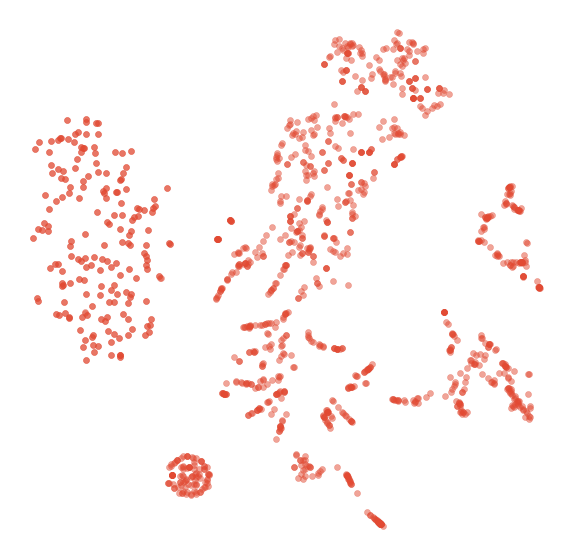

In [79]:
dataset = HSEDataset()
model = DuoGAE()
model.eval_lp(dataset, emb_type="diff2vec")
clear_output()
plot_points_tsne(model.gae.get_embeddings().data, figsize=(10, 10))

In [80]:
embs = model.gae.get_embeddings().data
kmeans_model = KMeans(n_clusters=3, random_state=1).fit(embs)
labels = kmeans_model.labels_
silhouette_score(embs, labels, metric='euclidean')

0.6641088

#### Evaluation of direct 2-d embeddings

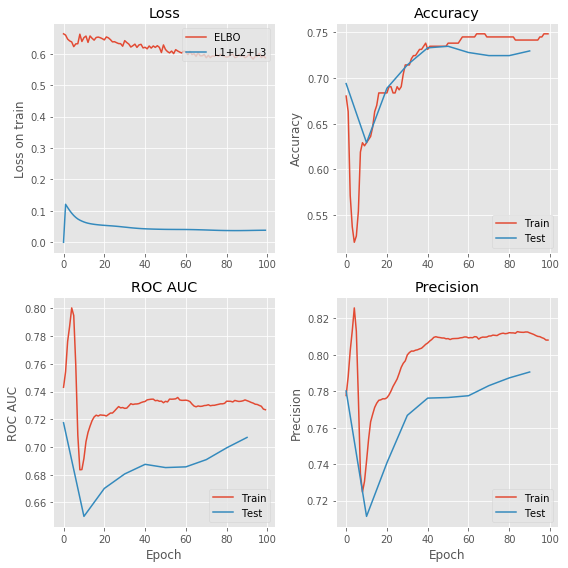

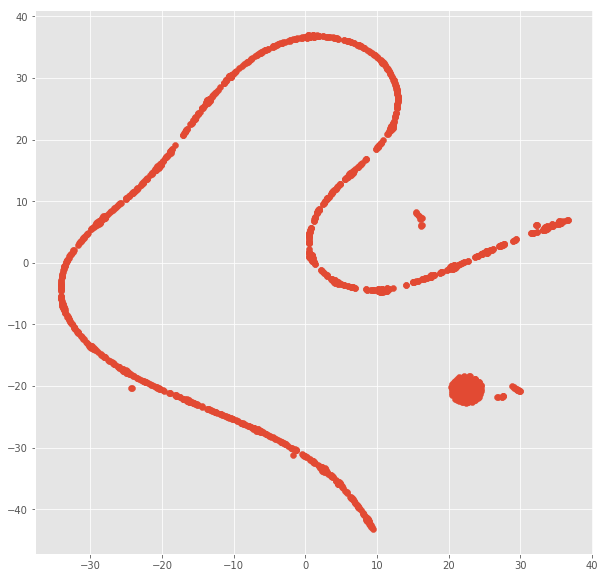

In [34]:
dataset = HSEDataset()
model = DuoGAE()
model.eval_lp(dataset, emb_type="node2vec", n_hidden=4, n_latent=2)
clear_output()
plot_points(model.gae.get_embeddings().data, figsize=(10, 10))

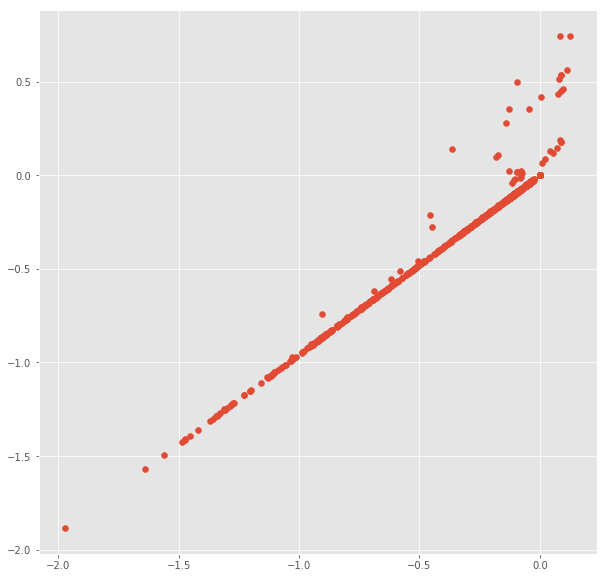

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

embs = model.gae.get_embeddings().data
vis_x = embs[:, 0]
vis_y = embs[:, 1]

plt.figure(figsize=(10, 10))
plt.scatter(vis_x, vis_y)
plt.show()

In [40]:
embs = model.gae.get_embeddings().data
kmeans_model = KMeans(n_clusters=3, random_state=1).fit(embs)
labels = kmeans_model.labels_
silhouette_score(embs, labels, metric='euclidean')

0.75396764

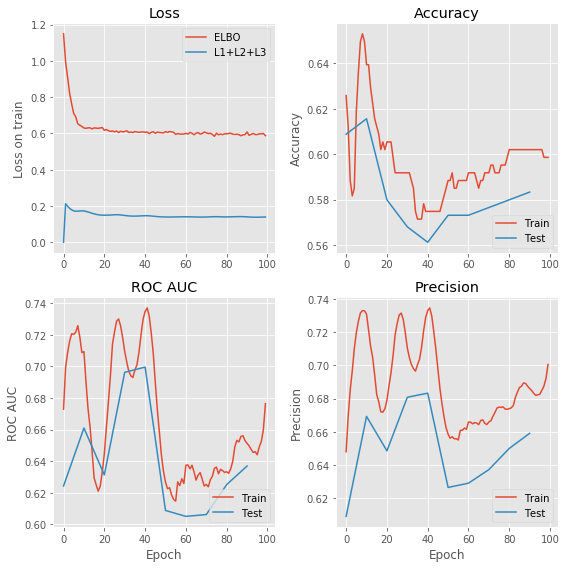

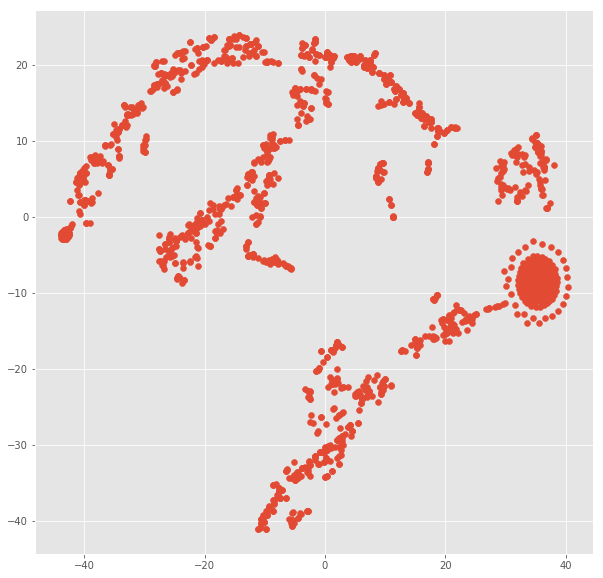

In [44]:
dataset = HSEDataset()
model = DuoGAE()
model.eval_lp(dataset, emb_type="node2vec", n_hidden=10, n_latent=2)
clear_output()
plot_points(model.gae.get_embeddings().data, figsize=(10, 10))

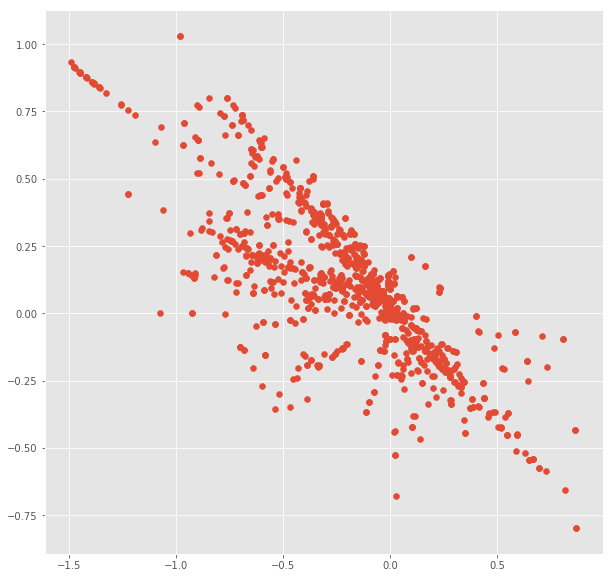

In [46]:
embs = model.gae.get_embeddings().data
vis_x = embs[:, 0]
vis_y = embs[:, 1]

plt.figure(figsize=(10, 10))
plt.scatter(vis_x, vis_y)
plt.show()

#### Features: concatenate or ignore sequence-based?

Preprocessing time: 0.52s
Preprocessing time: 13.45s
CPU times: user 2h 13min 4s, sys: 32min 31s, total: 2h 45min 35s
Wall time: 1h 41min 42s


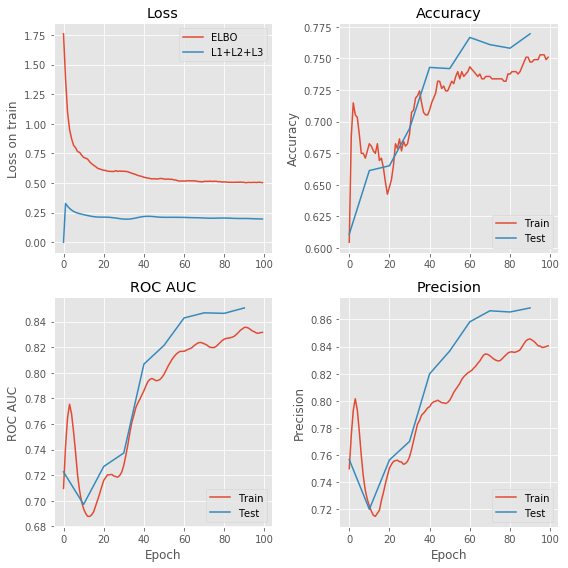

In [21]:
%%time
# Exp 5. Does sequence learning benefit existing features?
# Cora dataset - has node features

# same settings as above
reset_params = {}

seeds = list(range(3))

dataset = CoraDataset(compress_to=50) #16
model = DuoGAE()

results_hasfeats = {}

# everything is with node2vec here
for emb_type in tqdm_notebook(["dummy", "node2vec", "diff2vec"], leave=False):
    reset_params['emb_type'] = emb_type
    results_hasfeats[emb_type] = interval_evaluation_lp(dataset, model,
                                                       params=reset_params,
                                                       seeds=seeds)

save_result(to_mean_and_std(results_hasfeats), "hasfeats_cora")

In [22]:
load_result("hasfeats_cora")

{'diff2vec': {'accuracy': {'mean': 0.6884882985452245,
   'std': 0.023424268421430968},
  'ap_score': {'mean': 0.8752252802352193, 'std': 0.014852171205969373},
  'f1_score': {'mean': 0.746651009983129, 'std': 0.016174404292650203},
  'logloss': {'mean': 0.5563944372224764, 'std': 0.01578699263285198},
  'roc_score': {'mean': 0.8536084936514853, 'std': 0.018945229835642927}},
 'dummy': {'accuracy': {'mean': 0.5060088551549652,
   'std': 0.003821330162427124},
  'ap_score': {'mean': 0.65795185505242, 'std': 0.01880201388991097},
  'f1_score': {'mean': 0.6670939238580081, 'std': 0.002437314174741692},
  'logloss': {'mean': 0.6931401428841816, 'std': 2.0822455194342075e-06},
  'roc_score': {'mean': 0.6439142713460483, 'std': 0.016185519604664772}},
 'node2vec': {'accuracy': {'mean': 0.6976597090449084,
   'std': 0.016871573267993874},
  'ap_score': {'mean': 0.8687742368296495, 'std': 0.011321546823532072},
  'f1_score': {'mean': 0.7498721852940223, 'std': 0.010609282065064916},
  'logloss

In [3]:
%%time
# Exp 5. Does sequence learning benefit existing features?
# Cora dataset - has node features

# same settings as above
reset_params = {}

seeds = list(range(1))

dataset = CoraDataset()
model = DuoGAE()

results_hasfeats = {}

# everything is with node2vec here
for emb_type in tqdm_notebook(["dummy", "node2vec", "diff2vec"], leave=False):
    reset_params['emb_type'] = emb_type
    results_hasfeats[emb_type] = interval_evaluation_lp(dataset, model,
                                                       params=reset_params,
                                                       seeds=seeds)
save_result(to_mean_and_std(results_hasfeats), "hasfeats_cora_2")

Preprocessing time: 0.54s
Preprocessing time: 22.45s
CPU times: user 31min 39s, sys: 9min 4s, total: 40min 43s
Wall time: 31min 45s


In [4]:
load_result("hasfeats_cora_2")

{'diff2vec': {'accuracy': {'mean': 0.6973434535104365, 'std': 0.0},
  'ap_score': {'mean': 0.8786543516250135, 'std': 0.0},
  'f1_score': {'mean': 0.7498039215686274, 'std': 0.0},
  'logloss': {'mean': 0.5415762102323489, 'std': 0.0},
  'roc_score': {'mean': 0.8604106881168332, 'std': 0.0}},
 'dummy': {'accuracy': {'mean': 0.5398481973434535, 'std': 0.0},
  'ap_score': {'mean': 0.6609884815775698, 'std': 0.0},
  'f1_score': {'mean': 0.6586910626319493, 'std': 0.0},
  'logloss': {'mean': 0.6929341455351995, 'std': 0.0},
  'roc_score': {'mean': 0.6417586928264603, 'std': 0.0}},
 'node2vec': {'accuracy': {'mean': 0.6963946869070209, 'std': 0.0},
  'ap_score': {'mean': 0.8887068298661274, 'std': 0.0},
  'f1_score': {'mean': 0.7496087636932708, 'std': 0.0},
  'logloss': {'mean': 0.5314812472359759, 'std': 0.0},
  'roc_score': {'mean': 0.8711441729167642, 'std': 0.0}}}

#### GAE - NP (not finished)

In [ ]:
%%time
# Exp 5. diff2vec/node2vec
# TODO - same as above but on HSE

# same settings as above
reset_params = {}

seeds = list(range(1))

dataset = HSEDataset()
model = DuoGAE_NP()

results_seq = {}

# everything is with node2vec here
for emb_type in tqdm_notebook(["dummy", "node2vec", "diff2vec"], leave=False):
    reset_params['emb_type'] = emb_type
    results_seq[emb_type] = interval_evaluation_lp(dataset, model,
                                                   params=reset_params,
                                                   seeds=seeds)

save_result(to_mean_and_std(results_seq), "gae_np_hse")

Preprocessing time: 0.21s


Words
___

### Other hacks (alternating optimization, weighted diffusion, ...?) [<a style="color: green"> V </a>]

Preprocessing time: 0.03s
Preprocessing time: 0.03s


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


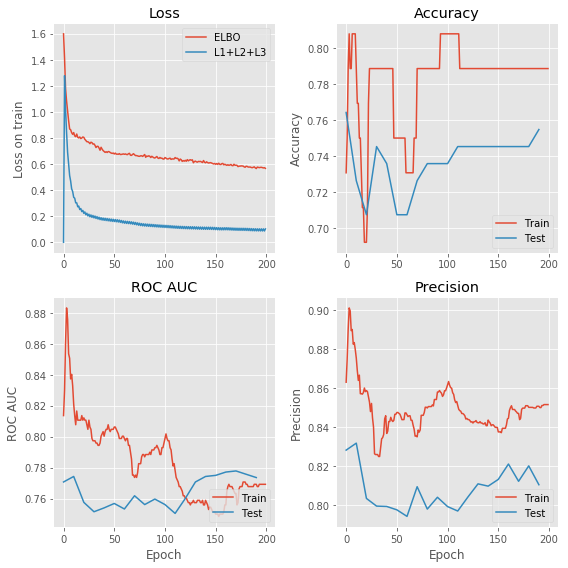

CPU times: user 2h 13min 36s, sys: 15min 9s, total: 2h 28min 45s
Wall time: 25min 50s


In [8]:
%%time

# Exp 6. try tweaking the model to train primal and dual sequentially

DataGen = AstroPhDataset  # HepThDataset

# same settings as above
reset_params = {}

subgraph_configs = [{'size': 500,  'seed': 10},
                    {'size': 500,  'seed': 20},
                    {'size': 1000, 'seed': 30},
                    {'size': 1000, 'seed': 40},
                    {'size': 1000, 'seed': 50}]

seeds = list(range(5))

model = DuoGAE()

results_alt = {}

# everything is with node2vec here
for alt in tqdm_notebook([False, True], leave=False):
    reset_params['alternate_training'] = alt
    reset_params['num_epochs'] = 200 if alt else 100
    tmp = defaultdict(list)
    for conf in subgraph_configs:
        dataset = DataGen(**conf)
        res = interval_evaluation_lp(dataset, model,
                                     params=reset_params,
                                     seeds=seeds)
        for met in res:
            tmp[met].extend(res[met])
    results_alt[alt] = copy(tmp)

# save_result(to_mean_and_std(results_alt), "alt_train_hepth")
save_result(to_mean_and_std(results_alt), "alt_train_astro")

In [7]:
load_result("alt_train_hepth")

{'false': {'accuracy': {'mean': 0.5646974472807991,
   'std': 0.08939507183703409},
  'ap_score': {'mean': 0.7338438212813451, 'std': 0.10344752600538339},
  'f1_score': {'mean': 0.6117407025787704, 'std': 0.09538619361410755},
  'logloss': {'mean': 0.6361043812751415, 'std': 0.03771403796651418},
  'roc_score': {'mean': 0.6614213678261872, 'std': 0.12449248226287318}},
 'true': {'accuracy': {'mean': 0.5616799852016278, 'std': 0.09277853547826417},
  'ap_score': {'mean': 0.7308069646507214, 'std': 0.08902994042151682},
  'f1_score': {'mean': 0.5914329241430878, 'std': 0.09851890195315763},
  'logloss': {'mean': 0.6333678039927289, 'std': 0.034038749906236176},
  'roc_score': {'mean': 0.6410323948876906, 'std': 0.12733313853001235}}}

In [9]:
load_result("alt_train_astro")

{'false': {'accuracy': {'mean': 0.5866954482464556,
   'std': 0.07419986992935909},
  'ap_score': {'mean': 0.7503392048319532, 'std': 0.0715897039996778},
  'f1_score': {'mean': 0.641115439276596, 'std': 0.07090082483007368},
  'logloss': {'mean': 0.6234431684175279, 'std': 0.0321110036735149},
  'roc_score': {'mean': 0.6814134629209511, 'std': 0.09179773641519405}},
 'true': {'accuracy': {'mean': 0.5820168425540987, 'std': 0.06709978231440213},
  'ap_score': {'mean': 0.7621215982946459, 'std': 0.07209619412898867},
  'f1_score': {'mean': 0.6272830630583038, 'std': 0.07184119037002952},
  'logloss': {'mean': 0.6121815208149852, 'std': 0.03899378834202638},
  'roc_score': {'mean': 0.684562856554664, 'std': 0.08857693111512147}}}

Other ideas:

* Weighted diffusion
* VGAE distribution

Preprocessing time: 0.14s
Preprocessing time: 6.02s
CPU times: user 2h 35min 46s, sys: 19min 42s, total: 2h 55min 28s
Wall time: 1h 8min 53s


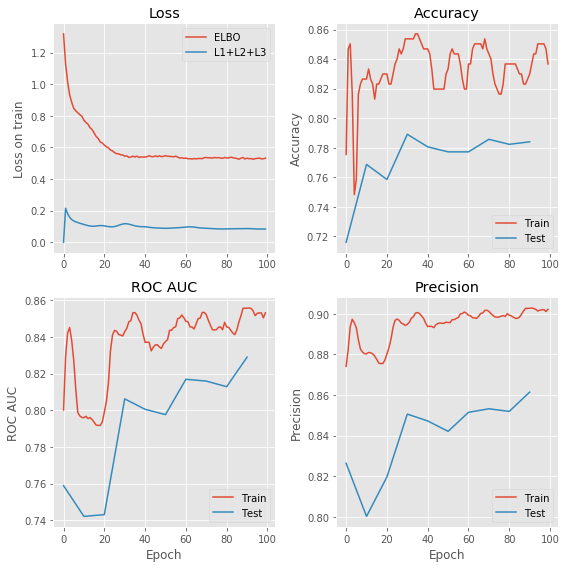

In [13]:
%%time

# Exp 7. weighted diffusion?

reset_params = {'emb_type': 'diff2vec'}

seeds = list(range(10))

dataset = HSEDataset()
model = DuoGAE()

results_weight_diff = {}

# everything is with node2vec here
for weighted in tqdm_notebook([False, True], leave=False):
    reset_params['weighted_seq'] = weighted
    results_weight_diff[weighted] = interval_evaluation_lp(dataset, model,
                                                   params=reset_params,
                                                   seeds=seeds)

save_result(to_mean_and_std(results_weight_diff), "weight_diff_hse")

In [5]:
load_result("weight_diff_hse")

{'false': {'accuracy': {'mean': 0.5382653061224489,
   'std': 0.015235095975483759},
  'ap_score': {'mean': 0.7616696869139943, 'std': 0.012036494273085145},
  'f1_score': {'mean': 0.6798936067928567, 'std': 0.007187459956077407},
  'logloss': {'mean': 0.6650184769230987, 'std': 0.02604935385189571},
  'roc_score': {'mean': 0.7113774931741405, 'std': 0.05202654497019641}},
 'true': {'accuracy': {'mean': 0.5510204081632654, 'std': 0.03437310022348254},
  'ap_score': {'mean': 0.7487229348829275, 'std': 0.03996270555801733},
  'f1_score': {'mean': 0.6829961828701424, 'std': 0.02251906901816916},
  'logloss': {'mean': 0.6541610743468329, 'std': 0.00818227815142374},
  'roc_score': {'mean': 0.7009319033735943, 'std': 0.03863190256087494}}}

## Big test against everyone


Compare DuoGAE, GAE, node2vec, diff2vec, Laplacian Eigenmaps and HOPE on different datasets, on the same train-test split per dataset.

#### On $d = 16$

In [9]:
# run us on all available datasets, using optimal parameters

dataset_gens = {'hepth': HepThDataset, 'astro': AstroPhDataset,
                'hse': HSEDataset, 'ppi': PPIDataset,
#                 'facebook': FacebookDataset,
                'blog_catalog': BlogCatalogDataset}

# 'facebook': FacebookDataset, - memory error on size=2000

# subgraph_configs = [{'size': 500,  'seed': 10},
#                     {'size': 500,  'seed': 20},
#                     {'size': 1000, 'seed': 30},
#                     {'size': 1000, 'seed': 40},
#                     {'size': 1000, 'seed': 50}]
# tt_seed = 10

subgraph_configs = [{'size': 2000, 'seed': 30},
                    {'size': 2000, 'seed': 40},
                    {'size': 2000, 'seed': 50}]

subgraph_configs_small = [{'size': 1000, 'seed': 30},
                          {'size': 1000, 'seed': 40},
                          {'size': 1000, 'seed': 50}]

tt_seed = 42

**DuoGAE**

Maybe change $d$ and number of epochs here

In [10]:
seeds = [tt_seed]

dataset_gens_ = {'ppi': PPIDataset}
# 'facebook': FacebookDataset,

tuned_params = {'num_epochs': 200,
                'emb_type': 'diff2vec'}

for name in dataset_gens_:
    print(name)
    model = DuoGAE()
    result = defaultdict(list)
    if name in ['facebook', 'blog_catalog']:
        confs = subgraph_configs_small
    else:
        confs = subgraph_configs
    for conf in confs:
        dataset = dataset_gens[name](**conf)
        res = interval_evaluation_lp(dataset, model,
                                     params=tuned_params,
                                     seeds=seeds)
        for met in res:
            result[met].extend(res[met])

    # done, saving
    save_result({met: {"mean": np.mean(v), "std": np.std(v)}
                for met, v in result.items()}, "duogae_diff_"+name)
    clear_output()

**i. Models of this class: GAE**

In [ ]:
# GAE: just set everything to zero

seeds = [tt_seed]

reset_params = {'emb_type': 'dummy',
                'mask': 0.0, 'mask_dual': 0.0,
                'lambd': 0.0, 'lambd_dual': 0.0, 'co_reg': 0.0}

#########################################################
# dataset_gens_ = {'ppi': PPIDataset, 'blog_catalog': BlogCatalogDataset}
for name in dataset_gens:
    print(name)
    model = DuoGAE()
    result = defaultdict(list)
    if name in ['facebook', 'blog_catalog']:
        confs = subgraph_configs_small
    else:
        confs = subgraph_configs
    for conf in confs:
        dataset = dataset_gens[name](**conf)
        res = interval_evaluation_lp(dataset, model,
                                     params={},
                                     seeds=seeds)
        for met in res:
            result[met].extend(res[met])

    # done, saving
    save_result({met: {"mean": np.mean(v), "std": np.std(v)}
                for met, v in result.items()}, "gae_"+name)
    clear_output()

In [ ]:
### Learn others: we need only the embeddings

def learn(model_gen, model_name):
    for name in dataset_gens:
        print(name)
        res = defaultdict(list)
        if name in ['facebook', 'blog_catalog']:
            confs = subgraph_configs_small
        else:
            confs = subgraph_configs
        for i, sg in enumerate(confs):
            dataset = dataset_gens[name](**sg)
            dataset.preprocess_train_test_split(seed=tt_seed)
            mod = model_gen()
            nx_G_train = nx.from_scipy_sparse_matrix(dataset.t["adj_train"])
            assert nx_G_train.number_of_nodes() == dataset.n
            mod.learn_embeddings(nx_G_train)
            emb = Variable(torch.FloatTensor(mod.get_embeddings()))
            accuracy, roc_score, ap_score, f1score, logloss = eval_gae_lp(dataset.t['test_edges'],
                                                                          dataset.t['test_edges_false'],
                                                                          emb, dataset.adj,
                                                                          threshold=0.5, verbose=False)
            res['accuracy_score'].append(accuracy)
            res['roc_score'].append(roc_score)
            res['ap_score'].append(ap_score)
            res['f1_score'].append(f1score)
            res['logloss'].append(logloss)

        save_result({met: {"mean": np.mean(v), "std": np.std(v)}
                    for met, v in res.items()}, model_name + "_" + name)
        clear_output()

**ii. Models of sequence-based class: Diff2vec**

In [ ]:
learn(Diff2Vec, "diff2vec_plain")

**ii. Models of sequence-based class: Node2vec**

In [ ]:
learn(Node2Vec, "node2vec_plain")

**iii. Models of matrix-factorization class**

Other guys implemented in the GEM library:

* Laplacian Eigenmaps --> =(

* HOPE

* Graph Factorization

**iii. Models of matrix-factorization class: Laplacian Eigenmaps**

In [ ]:
# has linear algebra problems
# learn(lambda: LaplacianEigenmaps(d=16), "LE")
# learn(lambda: LocallyLinearEmbedding(d=16), "LE")

**iii. Models of matrix-factorization class: HOPE**

In [ ]:
learn(lambda: HOPE(d=16, beta=0.01), "HOPE")

In [ ]:
learn(lambda: GraphFactorization(d=16, max_iter=10000, eta=1*10**-4, regu=1.0), "GrF")

#### Varying $d$ : graphics

In [123]:
RESULTS = pkl.load(open('RESULTS_234.pkl', 'rb'))
RESULTS_2 = pkl.load(open('RESULTS.pkl', 'rb'))
for name in RESULTS_2:
    RESULTS[name].extend(RESULTS_2[name])

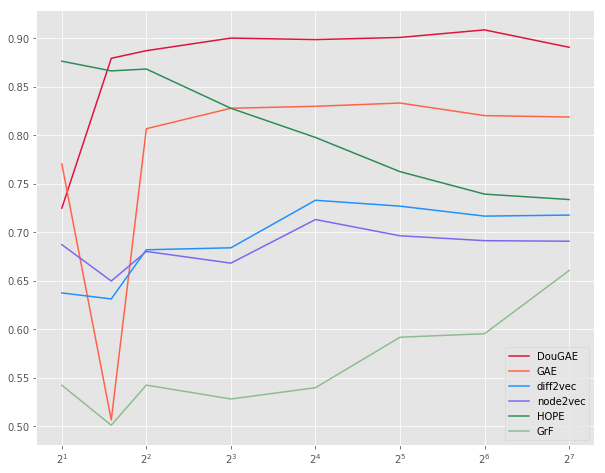

In [124]:
ds = [2, 3, 4, 2 ** 3, 2 ** 4, 2 ** 5, 2 ** 6, 2 ** 7]

# cmap=plt.cm.get_cmap("jet", 6)
colors = ['crimson', 'tomato', 'dodgerblue', 'mediumslateblue', 'seagreen', 'darkseagreen']

plt.figure(figsize=(10, 8))
           
for i, name in enumerate(RESULTS):
    res = RESULTS[name]
    if "plain" in name:
        name = name.split('_')[0]
    if name == 'gae':
        name = 'GAE'
    if name == 'duogae':
        name = 'DouGAE'
    plt.semilogx(ds, res, basex=2, label=name, c=colors[i])
    # plt.plot(ds, res, label=name)

plt.legend()
plt.show()

In [125]:
RESULTS = pkl.load(open('RESULTS_F1.pkl', 'rb'))

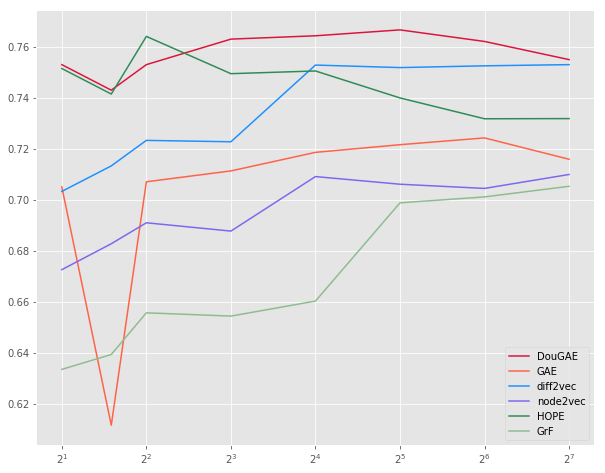

In [126]:

ds = [2, 3, 4, 2 ** 3, 2 ** 4, 2 ** 5, 2 ** 6, 2 ** 7]
plt.figure(figsize=(10, 8))
for i, name in enumerate(RESULTS):
    res = RESULTS[name]
    if "plain" in name:
        name = name.split('_')[0]
    if name == 'gae':
        name = 'GAE'
    if name == 'duogae':
        name = 'DouGAE'
    plt.semilogx(ds, res, basex=2, label=name, color=colors[i])
    # plt.plot(np.log2(ds), res, label=name)
plt.legend()
plt.show()

AstroPhDataset

diff2vec_plain
node2vec_plain
HOPE
GrF


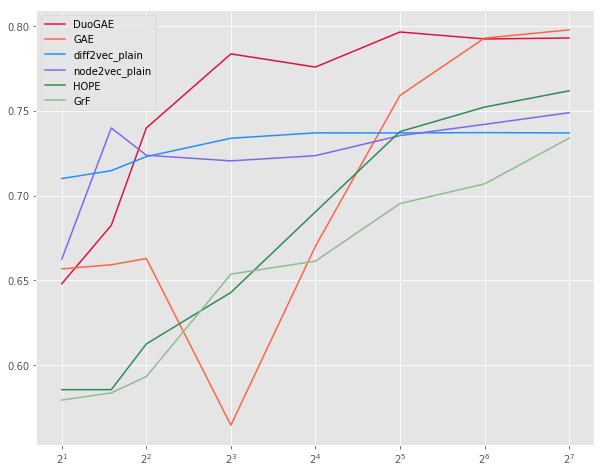

In [39]:
# ROC
RESULTS = pkl.load(open('RESULTS_ROC.pkl', 'rb'))
RESULTS_2 = pkl.load(open('RESULTS_ROC_others.pkl', 'rb'))

colors = ['crimson', 'tomato', 'dodgerblue', 'mediumslateblue', 'seagreen', 'darkseagreen']

ds = [2, 3, 4, 2 ** 3, 2 ** 4, 2 ** 5, 2 ** 6, 2 ** 7]
plt.figure(figsize=(10, 8))

for i, name in enumerate(['duogae', 'gae']):
    res = RESULTS[name]
    if name == 'gae':
        name = 'GAE'
    if name == 'duogae':
        name = 'DuoGAE'
    plt.semilogx(ds, res, basex=2, label=name, color=colors[i])

for j, name in enumerate(['diff2vec_plain', 'node2vec_plain', 'HOPE', 'GrF']):
    i = j + 2
    res = RESULTS_2[name]
    print(name)
    plt.semilogx(ds, res, basex=2, label=name, color=colors[i])
plt.legend()
plt.show()

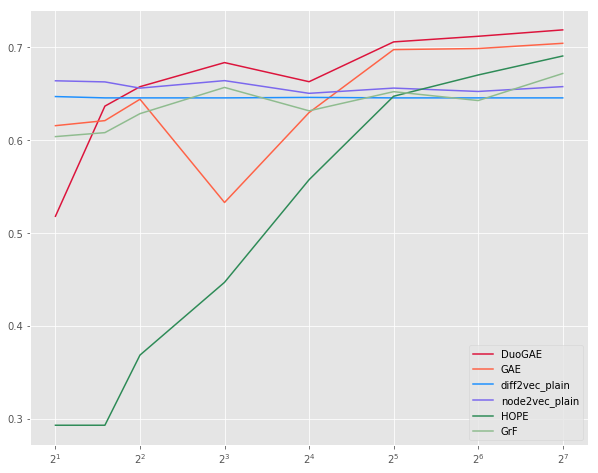

In [33]:
# F1
RESULTS = pkl.load(open('RESULTS_F1.pkl', 'rb'))
RESULTS_2 = pkl.load(open('RESULTS_F1_others.pkl', 'rb'))

colors = ['crimson', 'tomato', 'dodgerblue', 'mediumslateblue', 'seagreen', 'darkseagreen']

ds = [2, 3, 4, 2 ** 3, 2 ** 4, 2 ** 5, 2 ** 6, 2 ** 7]
plt.figure(figsize=(10, 8))

for i, name in enumerate(['duogae', 'gae']):
    res = RESULTS[name]
    if name == 'gae':
        name = 'GAE'
    if name == 'duogae':
        name = 'DuoGAE'
    plt.semilogx(ds, res, basex=2, label=name, color=colors[i])

for j, name in enumerate(['diff2vec_plain', 'node2vec_plain', 'HOPE', 'GrF']):
    i = j + 2
    res = RESULTS_2[name]
    plt.semilogx(ds, res, basex=2, label=name, color=colors[i])
plt.legend()
plt.show()

___

## Node classification

In two modes

### As downstream task

Compare DuoGAE against other algorithms for embedding generation such as node2vec

In [7]:
# dataset_gens = {'cora': CoraDataset}
dataset_gens = {'cora': CoraDataset, 'blog-catalog': BlogCatalogDataset}

subgraph_configs =  [{'size': 1000, 'seed': 30}]

def evaluate_classification(model_gen, model_name, seed=10):
    for name in dataset_gens:
        print(name)
        res = defaultdict(list)
        for i, sg in enumerate(subgraph_configs):
            dataset = dataset_gens[name](**sg)
            dataset.preprocess_train_test_split(seed=seed,
                                               train_test_split=(1., 0., 0.))
            mod = model_gen()
            nx_G_train = nx.from_scipy_sparse_matrix(dataset.t["adj_train"])
            assert nx_G_train.number_of_nodes() == dataset.n
            mod.learn_embeddings(nx_G_train)
            emb = mod.get_embeddings()
            
            np.random.seed(15)
            y = dataset.labels
            y = np.array([np.random.choice(np.where(line)[0],
              size=1) for line in dataset.labels], dtype='int')
            
            y_train, y_test, ind_train, ind_test = train_test_split(y, 
                                                        list(range(emb.shape[0])), 
                                                        test_size=0.2, random_state=seed)

            X_train = emb[ind_train, :].data
            X_test  = emb[ind_test, :].data

            rf = RandomForestClassifier(random_state=seed)
            rf.fit(X_train, y_train)
            y_pred = rf.predict(X_test)
#             gbc = GradientBoostingClassifier(random_state=seed)
#             gbc.fit(X_train, y_train)
#             y_pred = gbc.predict(X_test)
            
            accuracy = accuracy_score(y_test, y_pred)
            f1score = f1_score(y_test, y_pred, average='macro')
            # ap_score = average_precision_score(y_test, y_pred, average='micro')
            # roc_score = roc_auc_score(y_test, y_pred, average='micro')
            print(accuracy, f1score)
            res['accuracy_score'].append(accuracy)
            res['f1_score'].append(f1score)
            # res['roc_score'].append(roc_score)
            # res['ap_score'].append(ap_score)

        save_result({met: {"mean": np.mean(v), "std": np.std(v)}
                     for met, v in res.items()}, model_name + "_classification_" + name)

In [8]:
# # This is temporary,
# # TODO: training without train-test split

d = 32
# dataset = CoraDataset(compress_to=d)
dataset = BlogCatalogDataset(size=1000, seed=30)
dataset.noeval = True  # turn off evaluation
name = "blog-catalog"
model = DuoGAE()

res = defaultdict(list)

opt_res = model.eval_lp(dataset, emb_type="node2vec",
                        feat_dim=d, n_hidden=2 * d, n_latent=d,
                        dropout=0.01, dropout_dual=0.01,
                        mask=1e-2, mask_dual=1e-2,
                        lambd=0.2, lambd_dual=0.4, co_reg=0.1,
                        num_epochs=100, test_freq=10,
                        lr=1e-2, lr_reg=1e-5, seed=2,
                        threshold=0.6, verbose=False,
                        train_test_split=(1., 0., 0.))

emb = model.gae.get_embeddings()

np.random.seed(15)
y = dataset.labels
y = np.array([np.random.choice(np.where(line)[0],
              size=1) for line in dataset.labels], dtype='int')
y_train, y_test, ind_train, ind_test = train_test_split(y,
                                                        list(range(emb.shape[0])), 
                                                        test_size=0.2,
                                                        random_state=1)

X_train = emb[ind_train, :].data
X_test  = emb[ind_test, :].data

rf = RandomForestClassifier(random_state=10)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# gbc = GradientBoostingClassifier(random_state=10)
# gbc.fit(X_train, np.where(y_train)[1])
# y_pred = gbc.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1score = f1_score(y_test, y_pred, average='macro')
res['accuracy_score'].append(accuracy)
res['f1_score'].append(f1score)
print(accuracy, f1score)
save_result({met: {"mean": np.mean(v), "std": np.std(v)}
                   for met, v in res.items()}, "duogae_classification_" + name)

Sampling a 1000-node subgraph from original graph
Preprocessing time: 0.03s
Preprocessing time: 0.25s


KeyboardInterrupt: 

In [9]:
from Benchmarks.models import BaseBenchmarkWrapper
import pickle

Features have shape (2708, 1433)
Preprocessing time: 0.11s


0.44649446494464945 0.36657930419626755
Features have shape (2708, 1433)
Preprocessing time: 0.09s


0.4612546125461255 0.3821841194360896
Features have shape (2708, 1433)
Preprocessing time: 0.09s


0.4317343173431734 0.349318027936582
Features have shape (2708, 1433)
Preprocessing time: 0.09s


0.4261992619926199 0.3598095323646861
Features have shape (2708, 1433)
Preprocessing time: 0.09s


0.4797047970479705 0.39598589655228095


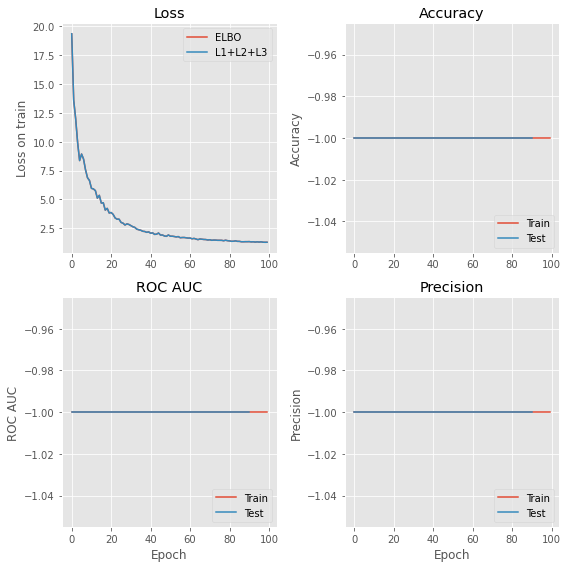

In [19]:
# # This is temporary,
# # TODO: training without train-test split

d = 32
# dataset = CoraDataset(compress_to=d)
acc = []
f1s = []
for i in range(5):
    dataset = CoraDataset(compress_to=d, size=1000, seed=i * 10)
#     dataset = BlogCatalogDataset(size=1000, seed=i * 10)
    dataset.noeval = True  # turn off evaluation
    name = "blog-catalog"
    model = BaseBenchmarkWrapper("gat", {})

    res = defaultdict(list)

    opt_res = model.eval_lp(dataset, emb_type="node2vec",
                            feat_dim=d, n_hidden=2 * d, n_latent=d,
                            dropout=0.01, dropout_dual=0.01,
                            mask=1e-2, mask_dual=1e-2,
                            lambd=0.2, lambd_dual=0.4, co_reg=0.1,
                            num_epochs=100, test_freq=10,
                            lr=1e-2, lr_reg=1e-5, seed=2,
                            threshold=0.6, verbose=False,
                            train_test_split=(1., 0., 0.))

    emb = model.model(model.features)

    np.random.seed(i)
    y = dataset.labels
    y = np.array([np.random.choice(np.where(line)[0],
                  size=1) for line in dataset.labels], dtype='int')
    y_train, y_test, ind_train, ind_test = train_test_split(y,
                                                            list(range(emb.shape[0])), 
                                                            test_size=0.2,
                                                            random_state=1)

    X_train = emb[ind_train, :].data
    X_test  = emb[ind_test, :].data

    rf = RandomForestClassifier(random_state=10)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    # gbc = GradientBoostingClassifier(random_state=10)
    # gbc.fit(X_train, np.where(y_train)[1])
    # y_pred = gbc.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1score = f1_score(y_test, y_pred, average='macro')
    res['accuracy_score'].append(accuracy)
    res['f1_score'].append(f1score)
    print(accuracy, f1score)
    save_result({met: {"mean": np.mean(v), "std": np.std(v)}
                       for met, v in res.items()}, "duogae_classification_" + name)
    acc.append(accuracy)
    f1s.append(f1score)

In [20]:
print(np.mean(acc), np.mean(f1s))

0.4490774907749078 0.37077537609718125


Features have shape (2708, 1433)
Preprocessing time: 0.09s


0.474169741697417 0.4234087920386103
Features have shape (2708, 1433)
Preprocessing time: 0.09s


0.4833948339483395 0.42928836546333987
Features have shape (2708, 1433)
Preprocessing time: 0.08s


0.544280442804428 0.5113946365169791
Features have shape (2708, 1433)
Preprocessing time: 0.08s


0.4833948339483395 0.4228373974804397
Features have shape (2708, 1433)
Preprocessing time: 0.10s


0.5313653136531366 0.4998869722041264


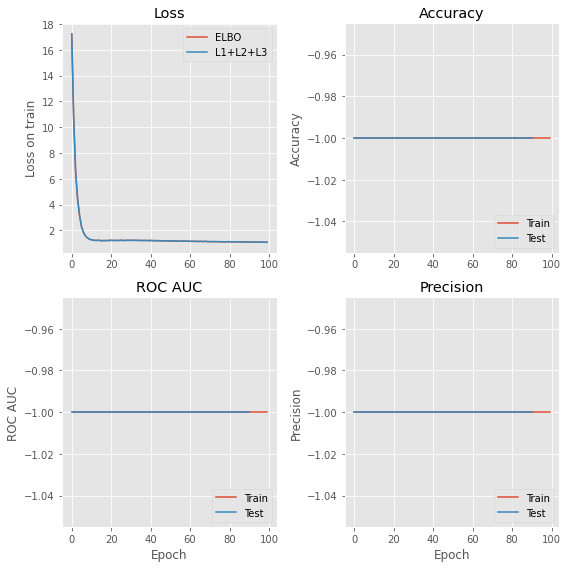

In [21]:
# # This is temporary,
# # TODO: training without train-test split

d = 32
# dataset = CoraDataset(compress_to=d)
acc = []
f1s = []
for i in range(5):
#     dataset = BlogCatalogDataset(size=1000, seed=i * 10)
    dataset = CoraDataset(compress_to=d, size=1000, seed=i * 10)
    dataset.noeval = True  # turn off evaluation
    name = "blog-catalog"
    model = BaseBenchmarkWrapper("graphsage", {})

    res = defaultdict(list)

    opt_res = model.eval_lp(dataset, emb_type="node2vec",
                            feat_dim=d, n_hidden=2 * d, n_latent=d,
                            dropout=0.01, dropout_dual=0.01,
                            mask=1e-2, mask_dual=1e-2,
                            lambd=0.2, lambd_dual=0.4, co_reg=0.1,
                            num_epochs=100, test_freq=10,
                            lr=1e-2, lr_reg=1e-5, seed=2,
                            threshold=0.6, verbose=False,
                            train_test_split=(1., 0., 0.))

    emb = model.model(model.features)

    np.random.seed(i)
    y = dataset.labels
    y = np.array([np.random.choice(np.where(line)[0],
                  size=1) for line in dataset.labels], dtype='int')
    y_train, y_test, ind_train, ind_test = train_test_split(y,
                                                            list(range(emb.shape[0])), 
                                                            test_size=0.2,
                                                            random_state=1)

    X_train = emb[ind_train, :].data
    X_test  = emb[ind_test, :].data

    rf = RandomForestClassifier(random_state=10)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    # gbc = GradientBoostingClassifier(random_state=10)
    # gbc.fit(X_train, np.where(y_train)[1])
    # y_pred = gbc.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1score = f1_score(y_test, y_pred, average='macro')
    res['accuracy_score'].append(accuracy)
    res['f1_score'].append(f1score)
    print(accuracy, f1score)
    save_result({met: {"mean": np.mean(v), "std": np.std(v)}
                       for met, v in res.items()}, "duogae_classification_" + name)
    acc.append(accuracy)
    f1s.append(f1score)

In [22]:
print(np.mean(acc), np.mean(f1s))

0.5033210332103321 0.4573632327406991


In [10]:
np.where(y_train)[1]

array([4, 0, 1, ..., 3, 1, 0])

Sampling a 1000-node subgraph from original graph
Preprocessing time: 0.01s
Preprocessing time: 0.19s
0.065 0.030764776335413278


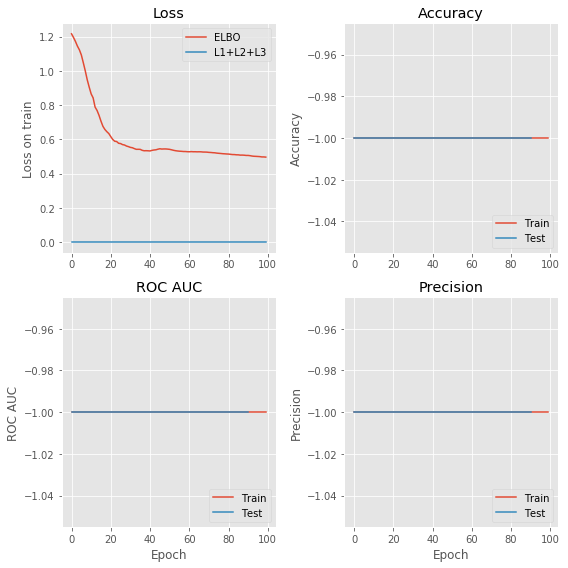

In [43]:
# GAE: uses dummy features without compression

d = 32
# dataset = CoraDataset()
# dataset.noeval = True  # turn off evaluation
# name = "cora"
dataset = BlogCatalogDataset(size=1000, seed=30)
dataset.noeval = True  # turn off evaluation
name = "blog-catalog"
model = DuoGAE()

res = defaultdict(list)

opt_res = model.eval_lp(dataset, emb_type="dummy",
                        feat_dim=d, n_hidden=2 * d, n_latent=d,
                        dropout=0.01, dropout_dual=0.01,
                        mask=0, mask_dual=0,
                        lambd=0, lambd_dual=0, co_reg=0,
                        num_epochs=100, test_freq=10,
                        lr=1e-2, lr_reg=1e-5, seed=2,
                        threshold=0.6, verbose=False,
                        train_test_split=(1., 0., 0.))

emb = model.gae.get_embeddings()

np.random.seed(15)
y = dataset.labels
y = np.array([np.random.choice(np.where(line)[0],
              size=1) for line in dataset.labels], dtype='int')

y_train, y_test, ind_train, ind_test = train_test_split(y,
                                                        list(range(emb.shape[0])), 
                                                        test_size=0.2,
                                                        random_state=1)

X_train = emb[ind_train, :].data
X_test  = emb[ind_test, :].data

rf = RandomForestClassifier(random_state=10)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# gbc = GradientBoostingClassifier(random_state=10)
# gbc.fit(X_train, y_train)
# y_pred = gbc.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1score = f1_score(y_test, y_pred, average='macro')
res['accuracy_score'].append(accuracy)
res['f1_score'].append(f1score)
print(accuracy, f1score)
save_result({met: {"mean": np.mean(v), "std": np.std(v)}
                   for met, v in res.items()}, "gae_classification_" + name)

In [44]:
evaluate_classification(Diff2Vec, 'diff2vec')
evaluate_classification(Node2Vec, 'node2vec')
evaluate_classification(lambda: GraphFactorization(d=d, max_iter=10000, eta=1*10**-4, regu=1.0), "GrF")
evaluate_classification(lambda: HOPE(d=d, beta=0.01), "HOPE")

blog-catalog
Sampling a 1000-node subgraph from original graph
Preprocessing time: 0.02s
0.085 0.01730117050275153
blog-catalog
Sampling a 1000-node subgraph from original graph
Preprocessing time: 0.02s
0.065 0.02054749172396231
blog-catalog
Sampling a 1000-node subgraph from original graph
Preprocessing time: 0.01s
		Iter id: 0, Objective: 2814.23, f1: 2811.05, f2: 3.17775
0.06 0.020548856916387435
blog-catalog
Sampling a 1000-node subgraph from original graph
Preprocessing time: 0.01s
SVD error (low rank): 0.557087
0.06 0.021094866796621186


### GCN

In [ ]:
# code here

Words

___

## Visualization

#### Multiclass

With DuoGAE:

The graph has 34 nodes and 77 edges
[ 0  1 10 11 12 13 14 15 16 17 18 19  2 20 21 22 23 24 25 26 27 28 29  3
 30 31 32 33  4  5  6  7  8  9]
[1 1 1 1 1 1 0 0 1 1 0 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 1 0 0]
Preprocessing time: 0.01s
Preprocessing time: 0.01s


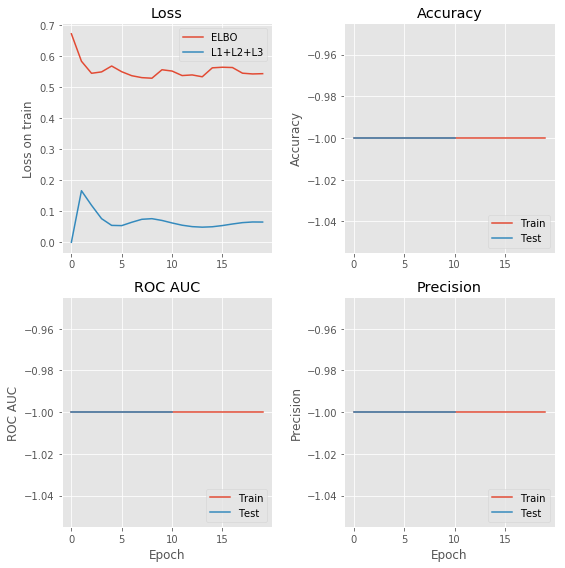

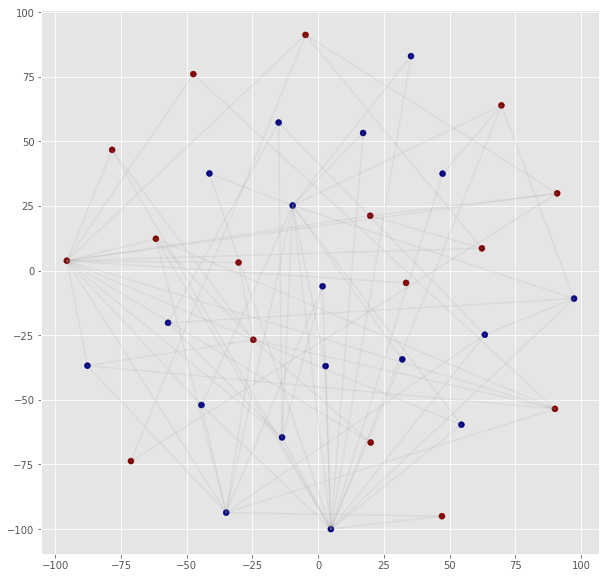

In [3]:
dataset = KarateDataset()
model = DuoGAE()

model.eval_lp(dataset, num_epochs=20,
              train_test_split=(1., 0., 0.),
              n_latent=2)
# clear_output()
emb = model.gae.get_embeddings().data
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(emb)
plot_with_classes(tsne_results, dataset.edgelist, dataset.labels, figsize=(10, 10))

In [100]:
plt.cm.cmap(1)

AttributeError: module 'matplotlib.cm' has no attribute 'cmap'

In [10]:
def plot_with_classes(tsne_results, edges, labels, label_names=None, figsize=(14, 10)):
    # dots
    #tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=600)
    #tsne_results = tsne.fit_transform(emb)

    # plotting
    x = tsne_results[:, 0]
    y = tsne_results[:, 1]
    colors = labels
    
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(1,1,1)  # two rows, one column, first plot
    
    if label_names is None:
        label_names = colors
    
    for edge in edges:
        a, b = edge
        a, b = int(a), int(b)
        plt.plot([x[a], x[b]], [y[a], y[b]],
                 color='lightgray', alpha=0.15, zorder=1)
    
    cmap = plt.cm.get_cmap("Dark2", len(set(labels)))
    for i, cla in enumerate(set(labels)):
        xc = [p for (j, p) in enumerate(x) if labels[j]==cla]
        yc = [p for (j, p) in enumerate(y) if labels[j]==cla]
        cols = [cmap(c) for (j,c) in enumerate(colors) if labels[j]==cla]
        plt.scatter(xc, yc, c=cols, label=label_names[cla], alpha=1., zorder=2)
        # plt.scatter(vis_x, vis_y, c=y_data)
    
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    ax.set_facecolor('white')  #'darkslategray'
    ax.grid(False)
    
    plt.legend()
    
    plt.show()

    
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# x = tsne_results[:, 0]
# y = tsne_results[:, 1]
# z = tsne_results[:, 1]
# ax.scatter(x, y, z)

def plot_with_classes_3d(tsne_results, edges, labels, label_names=None, figsize=(14, 10)):
    # dots
    #tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=600)
    #tsne_results = tsne.fit_transform(emb)

    # plotting
    x = tsne_results[:, 0]
    y = tsne_results[:, 1]
    z = tsne_results[:, 2]
    colors = labels

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    
    if label_names is None:
        label_names = colors
    
    for edge in edges:
        a, b = edge
        a, b = int(a), int(b)
        plt.plot([x[a], x[b]], [y[a], y[b]],
                 color='lightgray', alpha=0.15, zorder=1)
    
    cmap = plt.cm.get_cmap("Dark2", len(set(labels)))
    for i, cla in enumerate(set(labels)):
        xc = [p for (j, p) in enumerate(x) if labels[j]==cla]
        yc = [p for (j, p) in enumerate(y) if labels[j]==cla]
        zc = [p for (j, p) in enumerate(z) if labels[j]==cla]
        cols = [cmap(c) for (j,c) in enumerate(colors) if labels[j]==cla]
        plt.scatter(xc, yc, zc, c=cols, label=label_names[cla], alpha=1., zorder=2)
        # plt.scatter(vis_x, vis_y, c=y_data)
    
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    ax.set_facecolor('white')  #'darkslategray'
    ax.grid(False)
    
    plt.legend()
    
    plt.show()

    
def from_onehot(labels):
    return np.where(labels)[1]

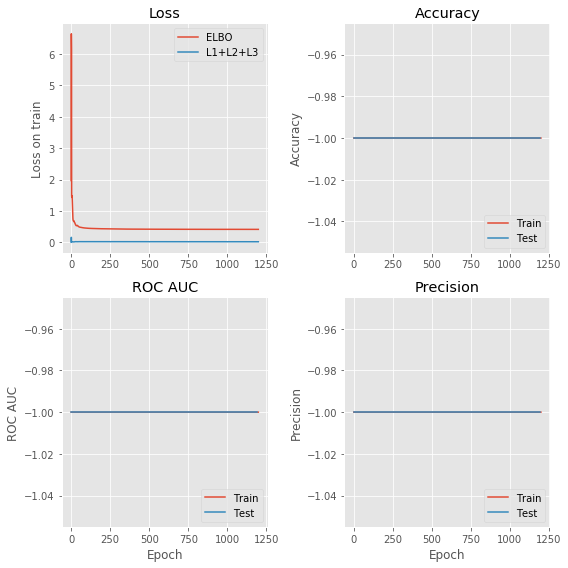

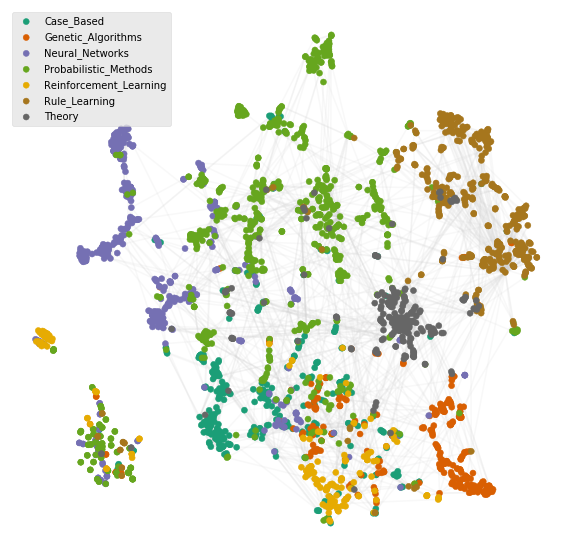

CPU times: user 4h 11min 50s, sys: 56min 51s, total: 5h 8min 42s
Wall time: 2h 40min 11s


In [157]:
%%time

d = 100

dataset = CoraDataset()  ## TODO: try without compression
dataset.noeval = True
model = DuoGAE()

model.eval_lp(dataset, num_epochs=1200,
              dropout=0., dropout_dual=0.,
              train_test_split=(1., 0., 0.),
              n_latent=d, n_hidden=10 * d, 
              feat_dim=d, emb_type="diff2vec")

clear_output()

emb = model.gae.get_embeddings().data
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=500)
tsne_results = tsne.fit_transform(emb)

labels = from_onehot(dataset.labels)
plot_with_classes(tsne_results, dataset.edgelist, 
                  labels, dataset.label_map,
                  figsize=(10, 10))

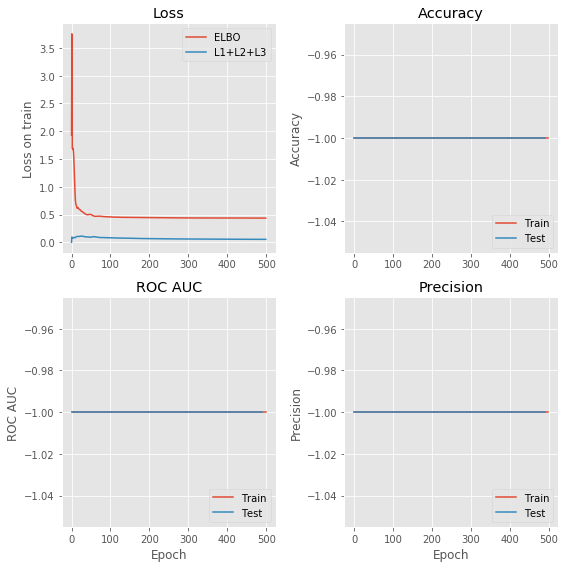

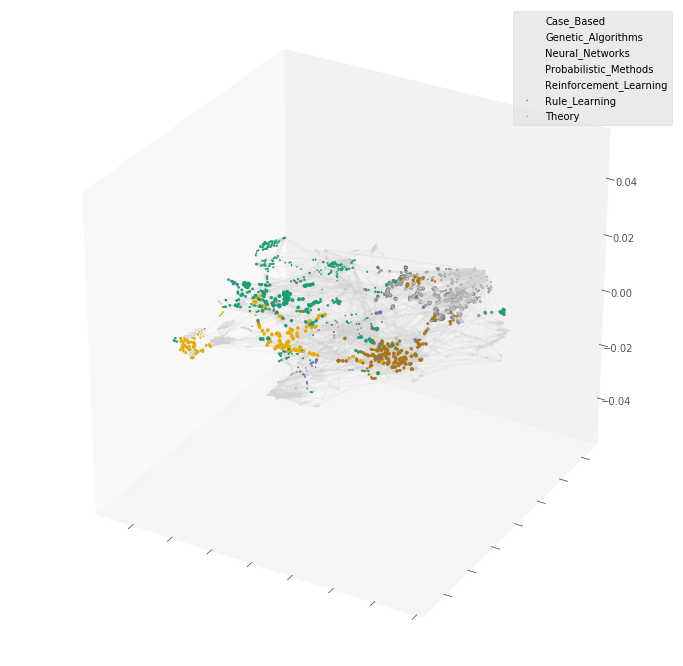

CPU times: user 1h 34min 2s, sys: 22min 44s, total: 1h 56min 47s
Wall time: 1h 8min 14s


In [14]:
%%time

d = 100

dataset = CoraDataset()
dataset.noeval = True
model = DuoGAE()

model.eval_lp(dataset, num_epochs=500,
              dropout=0., dropout_dual=0.,
              train_test_split=(1., 0., 0.),
              n_latent=d, n_hidden=4 * d, 
              feat_dim=d, emb_type="diff2vec")

clear_output()

emb = model.gae.get_embeddings().data
# tsne_results = emb
tsne = TSNE(n_components=3, verbose=0, perplexity=40, n_iter=500)
tsne_results = tsne.fit_transform(emb)

labels = from_onehot(dataset.labels)
plot_with_classes_3d(tsne_results, dataset.edgelist, 
                  labels, dataset.label_map,
                  figsize=(12, 12))

In [139]:
# Same but with diff2vec features

d = 2

dataset = CoraDataset(compress_to=50)
dataset.noeval = True
model = DuoGAE()

model.eval_lp(dataset, num_epochs=300,
              dropout=0., dropout_dual=0.,
              train_test_split=(1., 0., 0.),
              n_latent=d, n_hidden=20,
              feat_dim=20, emb_type="diff2vec")

clear_output()

emb = model.gae.get_embeddings().data
# tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
# tsne_results = tsne.fit_transform(emb)

labels = from_onehot(dataset.labels)
plot_with_classes(emb, dataset.edgelist, 
                  labels, dataset.label_map,
                  figsize=(10, 10))

KeyboardInterrupt: 

___

Diff2vec Plain:

Preprocessing time: 0.01s


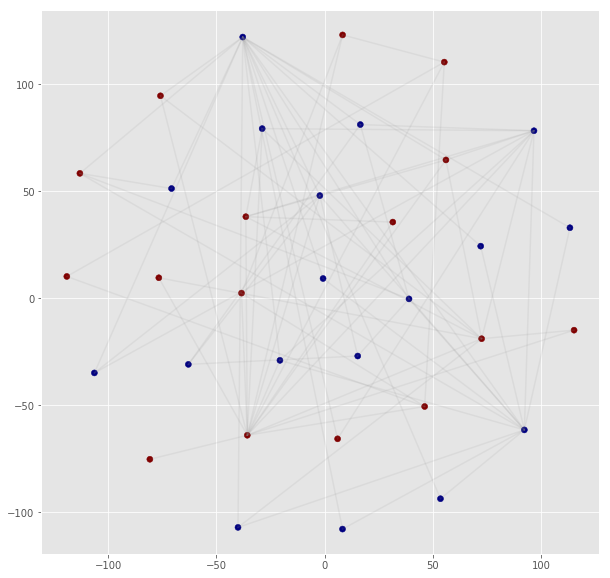

In [5]:
dataset.preprocess_train_test_split(seed=0, train_test_split=(1., 0., 0.))
# model = HOPE(d=2, beta=1.0)
model = Diff2Vec(d=2)
nx_G_train = nx.from_scipy_sparse_matrix(dataset.t["adj_train"])
assert nx_G_train.number_of_nodes() == dataset.n
model.learn_embeddings(nx_G_train)
emb = model.get_embeddings()
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(emb)
plot_with_classes(tsne_results, dataset.edgelist, dataset.labels, figsize=(10, 10))

Features have shape (2708, 1433)
Preprocessing time: 0.11s


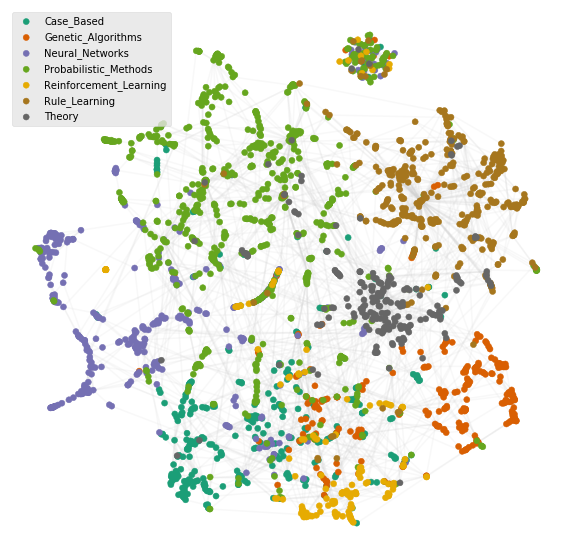

In [156]:
d = 100

# data prep
dataset = CoraDataset()
dataset.preprocess_train_test_split(seed=0, train_test_split=(1., 0., 0.))

# model
model = Diff2Vec(d=d)
# model = HOPE(d=2, beta=1.0)

# fit
nx_G_train = nx.from_scipy_sparse_matrix(dataset.t["adj_train"])
assert nx_G_train.number_of_nodes() == dataset.n
model.learn_embeddings(nx_G_train)

# reduce dim of embeddings
emb = model.get_embeddings()
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(emb)

# plot
labels = from_onehot(dataset.labels)
plot_with_classes(tsne_results, dataset.edgelist, 
                  labels, dataset.label_map,
                  figsize=(10, 10))

Node2vec:

Preprocessing time: 0.01s


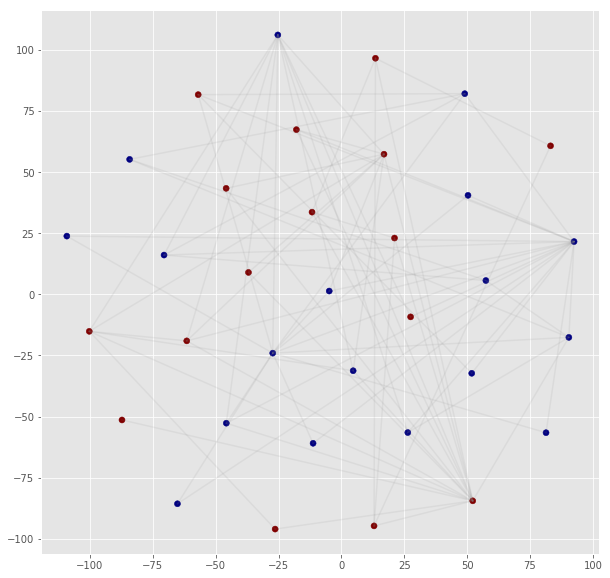

In [6]:
dataset.preprocess_train_test_split(seed=0, train_test_split=(1., 0., 0.))
model = Node2Vec(d=2)
nx_G_train = nx.from_scipy_sparse_matrix(dataset.t["adj_train"])
assert nx_G_train.number_of_nodes() == dataset.n
model.learn_embeddings(nx_G_train)
emb = model.get_embeddings()
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(emb)
plot_with_classes(tsne_results, dataset.edgelist, dataset.labels, figsize=(10, 10))

#### Edge embeddings and reconstruction

In [ ]:
from DuoGAE.preprocessing import make_incidence_matrix

d = 2
# fit
# TODO

node_emb = model.gae.get_embeddings()
edge_emb = model.dual_gae.get_embeddings()

commat = make_incidence_matrix(dataset.node2ind_map, dataset.edgelist)
degrees = commat.to_dense().sum(dim=1)
averages = commat @ edge_emb / degrees[:, np.newaxis]

# 1. plot averages across edges VS nodes

# 2. plot averages across nodes VS edges

# STUFF

Sampling a 1000-node subgraph from original graph
Walk iteration:
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10
Preprocessing time: 0.03s
Walk iteration:
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10
Preprocessing time: 0.05s


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"



Optimization Finished!


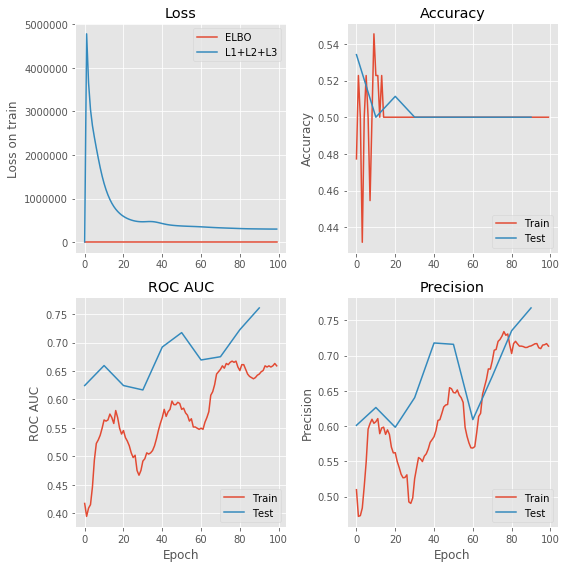

In [24]:
dataset = HepThDataset(size=1000, seed=10)
model = DuoGAE()

opt_res = model.fit(dataset,
                    emb_type="node2vec",
                    feat_dim=16,
                    mask=1e-2, mask_dual=1e-2,
                    lambd=2, lambd_dual=4, co_reg=1,
                    num_epochs=100,
                    lr=1e-2, seed=5,
                    threshold=0.6, verbose=False)

In [25]:
model.evaluate(dataset, threshold=0.6)

{'accuracy': 0.5,
 'ap_score': 0.7730298032548136,
 'f1_score': 0.0,
 'logloss': 0.6888780751713413,
 'roc_score': 0.7706611570247934}

Walk iteration:
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10
Preprocessing time: 0.03s
Walk iteration:
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10
Preprocessing time: 0.05s


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"



Optimization Finished!


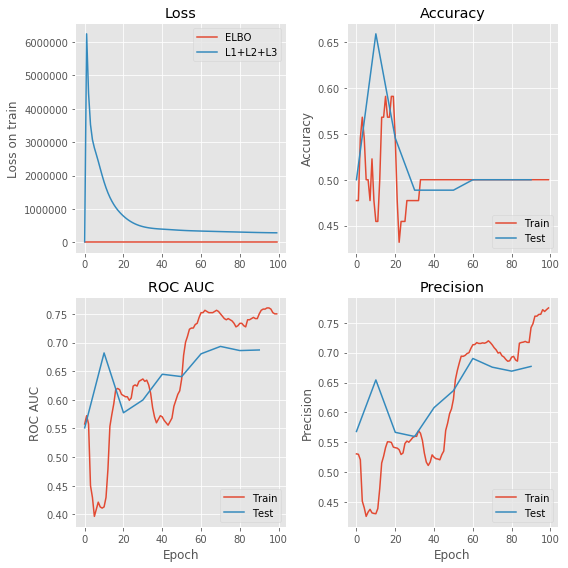

In [29]:
opt_res = model.fit(dataset,
                    emb_type="node2vec",feat_dim=16,
                    mask=1e-2, mask_dual=1e-2,
                    lambd=2, lambd_dual=4, co_reg=1,
                    num_epochs=100,
                    lr=1e-2, seed=5,
                    threshold=0.6, verbose=False)

In [30]:
model.evaluate(dataset, threshold=0.6)

{'accuracy': 0.5,
 'ap_score': 0.6871585675348347,
 'f1_score': 0.0,
 'logloss': 0.6908789082335268,
 'roc_score': 0.696797520661157}

### Stuff

No masking:

Sampling a 1000-node subgraph from original graph
Walk iteration:
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10
Preprocessing time: 0.03s
Walk iteration:
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10
Preprocessing time: 0.05s


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"



Optimization Finished!


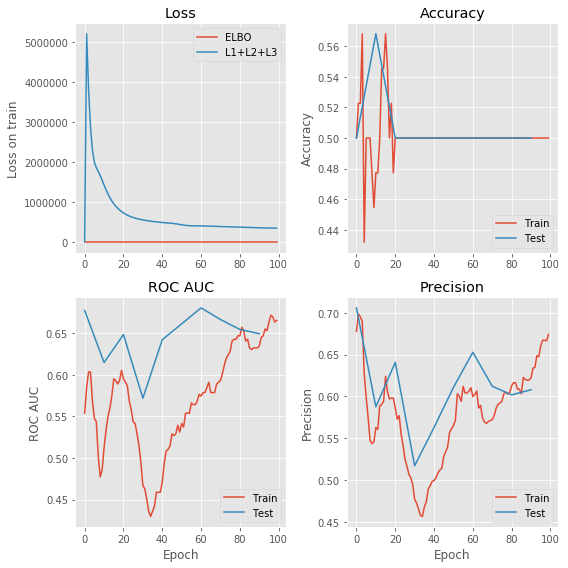

In [26]:
dataset = HepThDataset(size=1000, seed=10)
model = DuoGAE()

opt_res = model.fit(dataset,
                    emb_type="node2vec",feat_dim=16,
                    mask=0., mask_dual=0.,
                    lambd=2, lambd_dual=4, co_reg=1,
                    num_epochs=100,
                    lr=1e-2, seed=5,
                    threshold=0.6, verbose=False)

In [27]:
model.evaluate(dataset, threshold=0.6)

{'accuracy': 0.5,
 'ap_score': 0.6430518806153189,
 'f1_score': 0.0,
 'logloss': 0.6890284511478775,
 'roc_score': 0.6621900826446281}

Walk iteration:
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10
Preprocessing time: 0.03s
Walk iteration:
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10
Preprocessing time: 0.04s


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"



Optimization Finished!


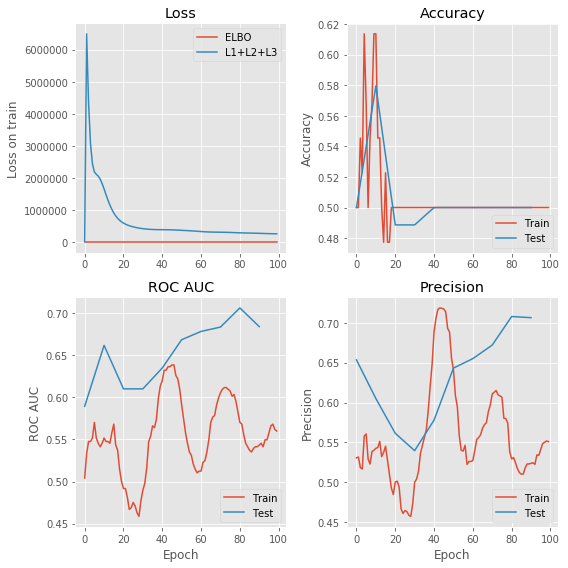

{'accuracy': 0.5,
 'ap_score': 0.6848744333256489,
 'f1_score': 0.0,
 'logloss': 0.690537388671327,
 'roc_score': 0.6895661157024793}

In [28]:
opt_res = model.fit(dataset,
                    emb_type="node2vec",feat_dim=16,
                    mask=0., mask_dual=0.,
                    lambd=2, lambd_dual=4, co_reg=1,
                    num_epochs=100,
                    lr=1e-2, seed=5,
                    threshold=0.6, verbose=False)

model.evaluate(dataset, threshold=0.6)

In [6]:
dataset = HepThDataset(size=1000, seed=10)
model = DuoGAE()

opt_res = model.fit(dataset,
                    emb_type="node2vec",feat_dim=16,
                    mask=0., mask_dual=0.,
                    lambd=2, lambd_dual=4, co_reg=1,
                    num_epochs=100,
                    lr=1e-2, seed=5,
                    threshold=0.6, verbose=False)

model.evaluate(dataset, threshold=0.6)

Sampling a 1000-node subgraph from original graph
Preprocessing time: 0.03s
Preprocessing time: 0.05s
4322389.0 4901333.5
3324490.0 3888432.25
2697997.5 3153379.75
2298896.8 2522297.25
2032182.6 2141729.25
1825812.6 1942734.5
1657394.9 1783257.75
1509201.2 1706749.75
1378670.2 1604630.875
1265526.0 1581812.75
1167074.1 1562886.75
1081936.0 1502295.25
1008852.06 1505206.0
945924.8 1485351.625
892567.25 1486659.0
848114.06 1442063.125
811917.0 1452724.5
782915.25 1433511.75
760399.25 1419605.5
743616.1 1450543.125
731313.0 1449975.375
722762.94 1433937.375
717195.9 1408299.625
714038.25 1393631.625
712273.9 1367396.0
711231.44 1347550.625
710247.25 1329620.25
708630.75 1294421.625
705478.56 1272828.125
700757.06 1258832.125
694431.3 1233541.5
686440.6 1221384.0
677399.6 1191623.625
667708.6 1164840.5
657928.56 1153559.25
648199.4 1138057.25
638893.06 1129801.75
630234.9 1108894.0
622234.06 1128471.75
614736.4 1108592.75
607496.4 1090551.875
600310.2 1086306.375
593242.3 1093333.625
58653

{'accuracy': 0.5,
 'ap_score': 0.7664050268276281,
 'f1_score': 0.0,
 'logloss': 0.6857378796746058,
 'roc_score': 0.7778925619834711}

### Choosing Seq model

In [ ]:
# node2vec vs diff2vec

Sampling a 1000-node subgraph from original graph
Preprocessing time: 0.02s
Preprocessing time: 0.04s



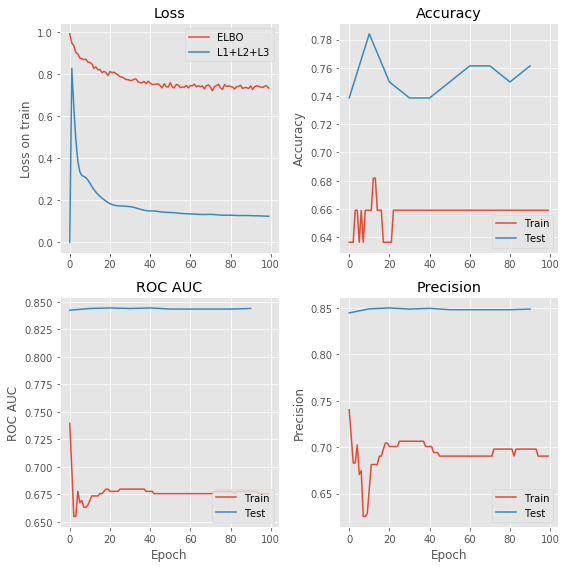

In [3]:
dataset = HepThDataset(size=1000, seed=10)
model = DuoGAE()

opt_res = model.fit(dataset,
                    emb_type="diff2vec",feat_dim=16,
                    mask=1e-2, mask_dual=1e-2,
                    lambd=2, lambd_dual=4, co_reg=1,
                    num_epochs=100,
                    lr=1e-2, seed=5,
                    threshold=0.6, verbose=False)

In [4]:
model.evaluate(dataset)

{'accuracy': 0.8295454545454546,
 'ap_score': 0.8488520538821824,
 'f1_score': 0.810126582278481,
 'logloss': 0.5779812091700861,
 'roc_score': 0.84400826446281}

## Trashbin

In [1]:
from DuoGAE.model import DuoGAE
from DuoGAE.datasets import *

In [2]:
from DuoGAE.diff2vec import Diff2Vec
from DuoGAE.node2vec import Node2Vec



dataset = HepThDataset(size=1000, seed=10)
dataset.preprocess_train_test_split(seed=0)

mod = Diff2Vec()

nx_G_train = nx.from_scipy_sparse_matrix(dataset.t["adj_train"])
assert nx_G_train.number_of_nodes() == dataset.n
mod.learn_embeddings(nx_G_train)
emb = mod.get_embeddings()


Sampling a 1000-node subgraph from original graph
Preprocessing time: 0.02s
384


In [3]:
emb[-10, :]

array([-0.27582988, -0.40454254, -0.47317785, -0.06478267, -0.5502494 ,
       -0.20891903,  0.57310325, -0.29254776,  0.29445273, -0.49625158,
       -0.94606245,  0.85905266, -0.95303649,  0.34518978,  0.49151087,
        1.41110611])

In [2]:
data = HSEDataset()

The graph has 1491 nodes and 2947 edges


In [3]:
dg = DuoGAE()

Preprocessing time: 0.21s
Preprocessing time: 12.24s



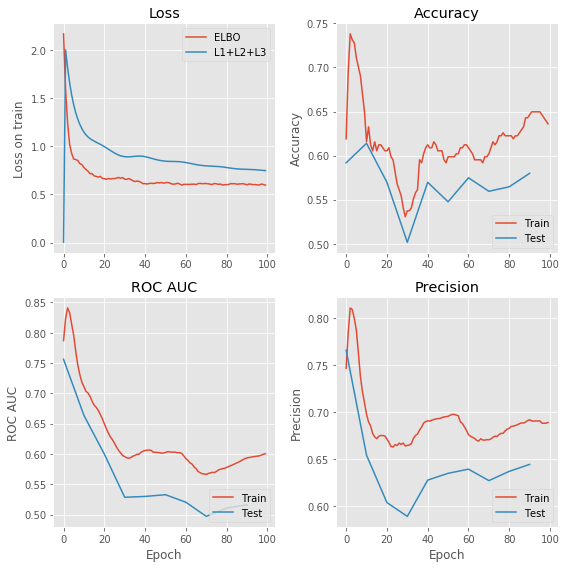

In [5]:
opt_res = dg.fit(data, num_epochs=100, seed=10, verbose=0)

In [8]:
dg.evaluate(data)

{'accuracy': 0.5238095238095238,
 'ap_score': 0.6506313659416314,
 'f1_score': 0.6751740139211138,
 'logloss': 0.6827372256527742,
 'roc_score': 0.5230922300893146}

In [2]:
data = HepThDataset()
dg = DuoGAE()
dg.fit(data, emb_type="node2vec", num_epochs=50, seed=10)

The graph has 27770 nodes and 352324 edges


KeyboardInterrupt: 

In [6]:
# dual_data = data.to_dual()

In [7]:
# dual_data.node2ind_map